In [1]:
# storing reports 
all_reports =[]
def store_report(report_dict, model_name, phase, storage_list,
                 U_min=None, U_max=None, mu_min=None, mu_max=None, U_step=None, mu_step=None):
    """
    Store classification report with model, phase, and grid parameters.
    """
    for cls, metrics in report_dict.items():
        if isinstance(metrics, dict): # per-class or averages
            storage_list.append({
                "Model": model_name,
                "Phase": phase,
                "Class": str(cls),
                "precision": metrics.get("precision"),
                "recall": metrics.get("recall"),
                "f1-score": metrics.get("f1-score"),
                "support": metrics.get("support"),
                "U_min": U_min, "U_max": U_max,
                "mu_min": mu_min, "mu_max": mu_max,
                "U_step": U_step, "mu_step": mu_step
            })
        else:                # e.g. "accuracy": float
            storage_list.append({
                "Model": model_name,
                "Phase": phase,
                "Class": str(cls),
                "precision": None,
                "recall": None,
                "f1-score": metrics,
                "support": None,
                "U_min": U_min, "U_max": U_max,
                "mu_min": mu_min, "mu_max": mu_max,
                "U_step": U_step, "mu_step": mu_step
            })


In [2]:
print(all_reports)

[]


In [3]:
# --- imports (add these near your other imports) ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from scikeras.wrappers import KerasClassifier


# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


import random
import os

# Ensure full reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
def run_models(
    models,X ,y ,
    U_min=0.0, U_max=15.0, 
    mu_min=0.0, mu_max=50.0, 
    U_step=0.1, mu_step=0.1
):
    """
    Run training, evaluation, decision boundary plotting, and prediction reports.
    Default grid limits: U∈[0,15], μ∈[0,50], step=0.1.
    Override using keyword args, e.g. run_models(models, U_max=25, mu_max=60).
    """


    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25, random_state=42,
        stratify=y
    )

    ##plot 1##
    #Plot True phase diagram
    plt.figure(figsize=(9,6))
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue','red']))
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū"); plt.ylabel("μ̄")
    plt.title("True Phase Diagram")
    plt.grid(True)
    plt.show()
 
    '''
    ---------- 3) Train + Evaluate ----------
    '''

    # ---------- 4) Plot decision boundary on training domain ----------
    def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
        x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
        y_min, y_max = X["Mubar"].min(), X["Mubar"].max()

        # Clip negatives if needed
        x_min = max(0, x_min)
        y_min = max(0, y_min)


        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, grid_res),
            np.linspace(y_min, y_max, grid_res)
        )
        grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
        Z = model.predict(grid_df).reshape(xx.shape)
    
    
        plt.figure(figsize=(9, 6))
        plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)

            # Filter training points so negative μ̄ don’t affect the axis
        mask = X["Mubar"] >= 0
        plt.scatter(
            X.loc[mask, "Ubar"], 
            X.loc[mask, "Mubar"], 
            c=y.loc[mask],
            s=10, cmap=ListedColormap(['blue', 'red']),
            edgecolor='k', linewidth=0.2
        )
        # plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
        plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
        plt.clim(-0.5, 1.5)
        plt.xlabel("Ū")
        plt.ylabel("μ̄")
        plt.title(title)
        plt.grid(True)
        plt.show()

        
    # def train_test(models,X_tain,y_train):
    for name, model in models.items():
            model.fit(X_train, y_train)

            # Plot Training Results 
            
            # plot_decision_boundary(model, X, y, title="T", grid_res=300):
            
            y_pred = model.predict(X_test)
            print(f"\n📊 Classification Report for {name}:")
            report_test = classification_report(y_test, y_pred, digits=4, output_dict=True)
            store_report(report_test, name, "test", all_reports,
                         U_min, U_max, mu_min, mu_max, U_step, mu_step)
            print(classification_report(y_test, y_pred, digits=4))
    
        
    
    
    for name,model  in models.items():
        # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
        clf = model  # or "LogReg-Poly2" or "RF-Shallow"
        
        plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
        
        # # ---------- 5) Predict on an extended grid (extrapolation) ----------
        # U_min, U_max = 0.0, 15.0   # extend beyond training range
        # mu_min, mu_max = 0.0, 50.0
        # U_step, mu_step = 0.1, 0.1
    
        
        U_vals = np.arange(U_min, U_max + U_step, U_step)
        mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
        U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
        
        grid_ext = pd.DataFrame({
            "Ubar": U_grid.ravel(),
            "Mubar": mu_grid.ravel()
        })
        
        pred_ext = clf.predict(grid_ext)
    
        phase_map = pred_ext.reshape(U_grid.shape)
        
        plt.figure(figsize=(9, 6))

        # if we want to see the predict of unknown datapoints and tarining prediction on the known datapoints comparisions
        # # Background prediction (gray/orange)
        # plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
        
        # # Overlay true training data (blue/red)
        # plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
        

        plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
        plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
        plt.clim(-0.5, 1.5)
        plt.xlabel("Ū")
        plt.ylabel("μ̄")
        plt.title("Predicted Phase Diagram for Model ")
        plt.grid(True)
        plt.show()
        
        # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
        # Only compare inside the original data domain (U≤15, μ≤50)
        mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
        grid_in_domain = grid_ext[mask_domain].copy()
        pred_in_domain = clf.predict(grid_in_domain)
          
       
        df_lookup = df.copy()
        df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
        df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
        lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
        lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
        
        grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
        grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
        true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
        
        # Drop NaNs (grid points that don't map exactly to a dataset point)
        valid = ~pd.isna(true_labels)
        true_labels = true_labels[valid].astype(int)
        pred_labels = pred_in_domain[valid]
        
        print(f"\n📊 Classification Report For Prediction using Model {name} :")
        report_pred = classification_report(true_labels, pred_labels, digits=4, output_dict=True)
        store_report(report_pred, name, "prediction", all_reports,
                     U_min, U_max, mu_min, mu_max, U_step, mu_step)
        print(classification_report(true_labels, pred_labels, digits=4))


In [6]:
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

print( " Initial Data", df)

 Initial Data           t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0

In [7]:
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])


# --- improved model builder ---
def build_keras_strong(hidden=(256, 256, 128), dropout=0.05, l2=1e-5, lr=2e-3):
    reg = regularizers.l2(l2)
    inputs = keras.Input(shape=(2,))
    x = inputs
    for h in hidden:
        x = layers.Dense(h, activation='relu', kernel_regularizer=reg)(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

keras_callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, min_lr=1e-5)
]

keras_nn_plus = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KerasClassifier(
        model=build_keras_strong,
        hidden=(512, 256, 128),
        dropout=0.05,
        l2=1e-5,
        lr=2e-3,
        epochs=500,
        batch_size=512,
        verbose=0,
        random_state=42,
        fit__validation_split=0.15,
        fit__callbacks=keras_callbacks
    ))
])


In [8]:
def make_multitask(input_dim=2, hidden=(64,64)):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi2_out = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out = layers.Dense(1, activation="relu", name="rho")(x)

    model = keras.Model(inputs, [phase_out, phi2_out, rho_out])
    model.compile(
        optimizer="adam",
        loss={"phase":"binary_crossentropy", "phi2":"mse", "rho":"mse"},
        loss_weights={"phase":1.0, "phi2":0.5, "rho":0.5},
        metrics={"phase":"accuracy"}
    )
    return model


In [9]:
def make_single_phase(input_dim=2, hidden=(64,64)):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    model = keras.Model(inputs, phase_out)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

models = {
    "SinglePhase": KerasClassifier(model=make_single_phase, epochs=20, batch_size=32, verbose=0)
}

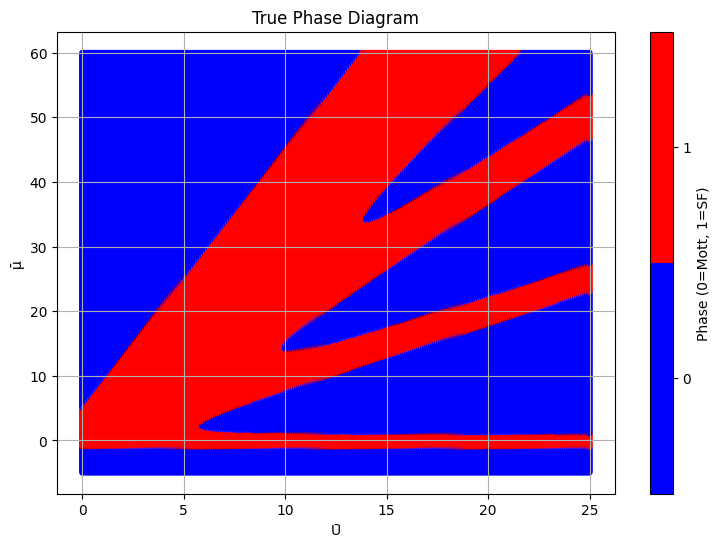


📊 Classification Report for SinglePhase:
              precision    recall  f1-score   support

           0     0.9956    0.9690    0.9821     24363
           1     0.9559    0.9936    0.9744     16488

    accuracy                         0.9789     40851
   macro avg     0.9758    0.9813    0.9783     40851
weighted avg     0.9796    0.9789    0.9790     40851



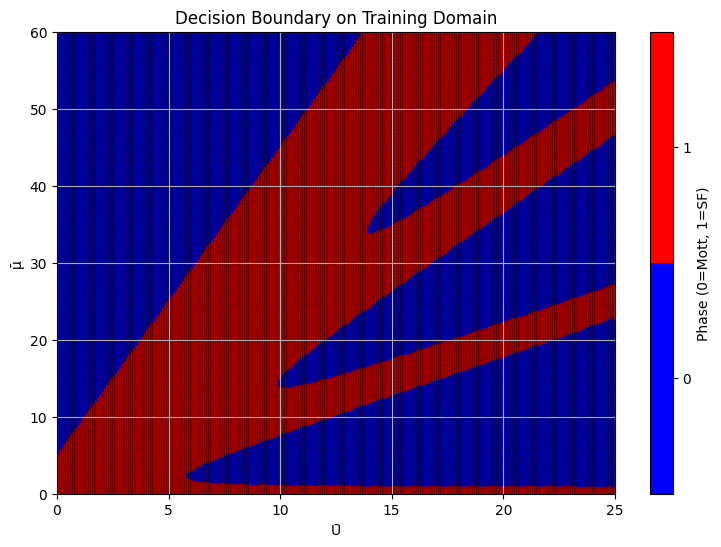

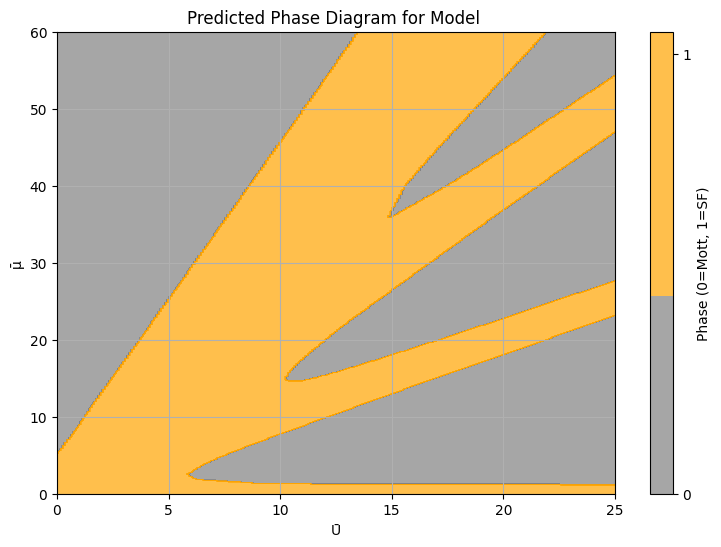


📊 Classification Report For Prediction using Model SinglePhase :
              precision    recall  f1-score   support

           0     0.9943    0.9650    0.9794     87410
           1     0.9537    0.9924    0.9727     63441

    accuracy                         0.9765    150851
   macro avg     0.9740    0.9787    0.9761    150851
weighted avg     0.9772    0.9765    0.9766    150851



In [10]:
# # run_models(models, X, y, U_max=25, mu_max=60)
# models = {
#     # "MLP": mlp,
#     # "Keras-NN-Plus": keras_nn_plus, # <-- new improved model
#     # "PINN": KerasClassifier(model=make_pinn_simple, epochs=20, batch_size=32, verbose=0)
    
# }
# from scikeras.wrappers import KerasClassifier

# models = {
#     # "PINN": KerasClassifier(model=make_pinn, epochs=20, batch_size=32, verbose=0),
#     "MultiTask": KerasClassifier(model=make_multitask, epochs=20, batch_size=32, verbose=0)
#     # "BNN": KerasClassifier(model=make_bnn, epochs=20, batch_size=32, verbose=0),
#     # CNN and GNN need special dataset formatting → separate loop
# }

# models = {
#     "SinglePhase": KerasClassifier(model=make_single_phase, epochs=20, batch_size=32, verbose=0)
# }

run_models(models,X,y,U_max=25,mu_max=60) 

In [11]:
# Prepare multi-task targets
y_phase = df["Phase"].values
y_phi2  = df["Phi2"].values
y_rho   = df["Density"].values

# Split data
X_train, X_test, y_phase_train, y_phase_test, y_phi2_train, y_phi2_test, y_rho_train, y_rho_test = train_test_split(
    X, y_phase, y_phi2, y_rho, test_size=0.25, random_state=42, stratify=y_phase
)

# Build model
multi_model = make_multitask()

# Train
history = multi_model.fit(
    X_train,
    {"phase": y_phase_train, "phi2": y_phi2_train, "rho": y_rho_train},
    validation_data=(X_test, {"phase": y_phase_test, "phi2": y_phi2_test, "rho": y_rho_test}),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Evaluate
results = multi_model.evaluate(
    X_test, {"phase": y_phase_test, "phi2": y_phi2_test, "rho": y_rho_test}
)
print("Evaluation:", results)


Epoch 1/30
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.4426 - phase_accuracy: 0.8927 - phase_loss: 0.2583 - phi2_loss: 0.2214 - rho_loss: 0.1471 - val_loss: 0.1470 - val_phase_accuracy: 0.9666 - val_phase_loss: 0.1145 - val_phi2_loss: 0.0540 - val_rho_loss: 0.0110
Epoch 2/30
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1214 - phase_accuracy: 0.9670 - phase_loss: 0.0945 - phi2_loss: 0.0340 - rho_loss: 0.0199 - val_loss: 0.0883 - val_phase_accuracy: 0.9717 - val_phase_loss: 0.0726 - val_phi2_loss: 0.0215 - val_rho_loss: 0.0099
Epoch 3/30
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0879 - phase_accuracy: 0.9749 - phase_loss: 0.0680 - phi2_loss: 0.0242 - rho_loss: 0.0157 - val_loss: 0.0861 - val_phase_accuracy: 0.9682 - val_phase_loss: 0.0701 - val_phi2_loss: 0.0223 - val_rho_loss: 0.0096
Epoch 4/30
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0745 - phase_accuracy: 0.9783 - phase_loss: 0.0577 - phi2_loss: 0.0206 - rho_loss: 0.0129 - val_loss: 0.0889 - val

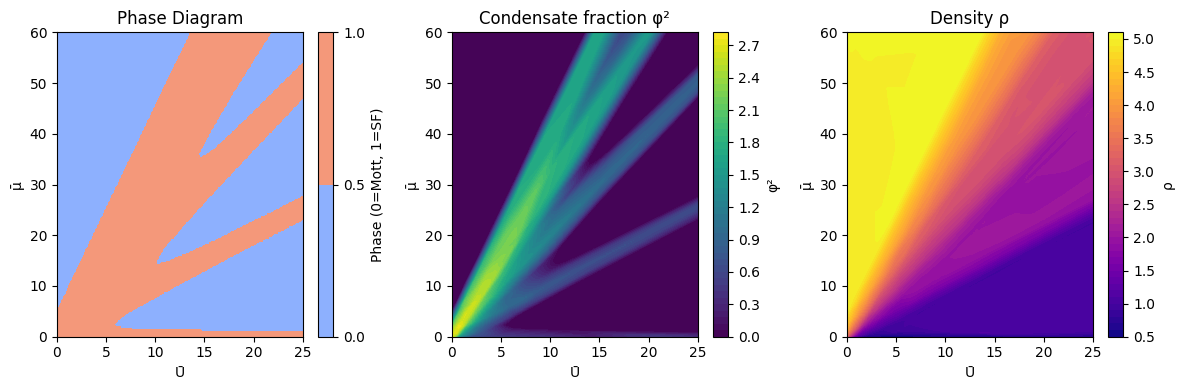

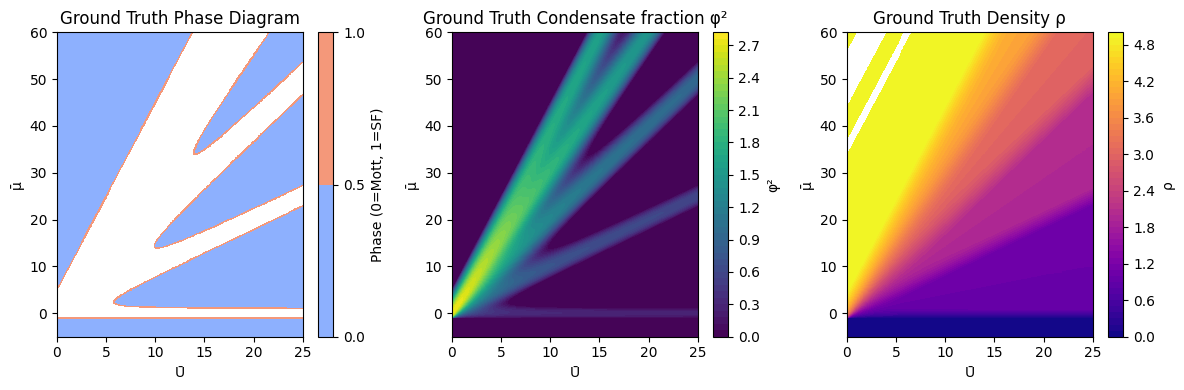

In [12]:
# Define grid in correct physics ranges
U_vals = np.linspace(0, 25, 200)   # x-axis
mu_vals = np.linspace(0, 60, 200)  # y-axis
UU, MU = np.meshgrid(U_vals, mu_vals)

X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1)

# Predict
phase_pred, phi2_pred, rho_pred =multi_model.predict(X_grid, verbose=0)

# Reshape
phase_pred = (phase_pred > 0.5).astype(int).reshape(UU.shape)
phi2_pred = phi2_pred.reshape(UU.shape)
rho_pred = rho_pred.reshape(UU.shape)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.contourf(UU, MU, phase_pred, levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Phase Diagram")

plt.subplot(1,3,2)
plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Density ρ")

plt.tight_layout()
plt.show()

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()



## Reduced datset

Reduced dataset summary:
Phase
1    2684
0    2000
Name: count, dtype: int64
Reduced dataset shape: (4684, 8)
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.1076 - phase_accuracy: 0.7267 - phase_loss: 0.5998 - phi2_loss: 0.5990 - rho_loss: 2.4142 - val_loss: 1.4374 - val_phase_accuracy: 0.8002 - val_phase_loss: 0.5593 - val_phi2_loss: 0.6589 - val_rho_loss: 1.0971
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2738 - phase_accuracy: 0.8013 - phase_loss: 0.5111 - phi2_loss: 0.5990 - rho_loss: 0.9266 - val_loss: 1.2437 - val_phase_accuracy: 0.8164 - val_phase_loss: 0.4992 - val_phi2_loss: 0.6589 - val_rho_loss: 0.8292
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0896 - phase_accuracy: 0.8258 - phase_loss: 0.4530 - phi2_loss: 0.5990 - rho_loss: 0.6745 - val_loss: 1.0630 - val_phase_accuracy: 0.8292 - val_phase_loss: 0.4458 - val_phi2_loss: 0.6589 - val_rho_loss: 0.5740
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9175 - phase

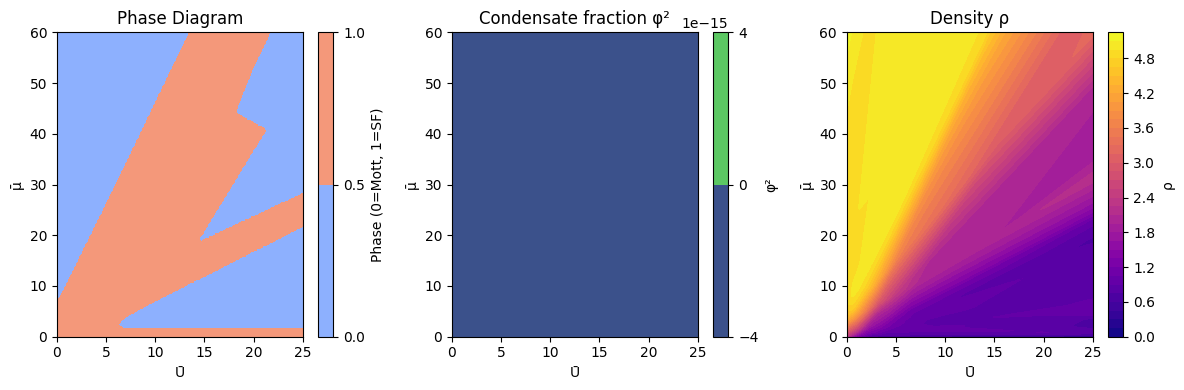

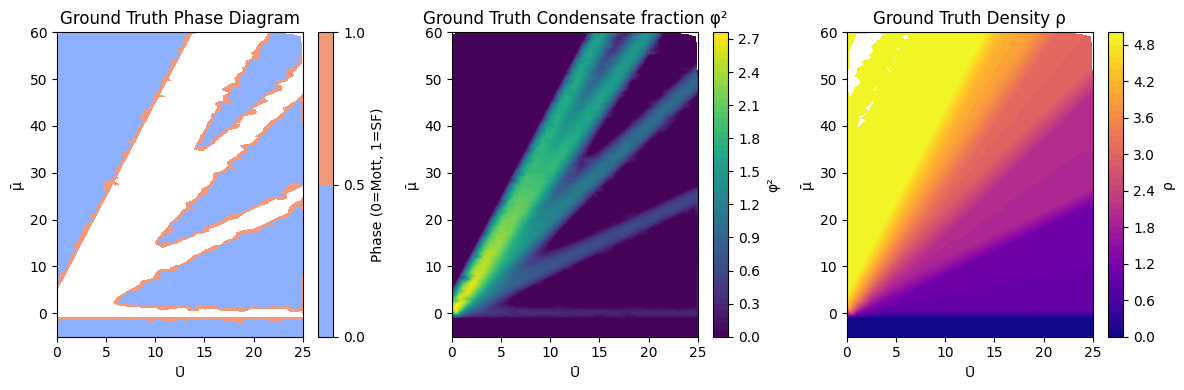

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid



# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)


df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])

df_reduced = df_reduced.reset_index(drop=True)

print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())
# Use reduced dataset
df = df_reduced.reset_index(drop=True)

print("Reduced dataset shape:", df.shape)

# pinn = make_pinn()
# pinn.fit(X, y, epochs=50, batch_size=256, validation_split=0.2)


# print( " Initial Data", df)


# Features: use Ubar and Mubar only
X = df[["Ubar", "Mubar"]].values

# Prepare multi-task targets
y_phase = df["Phase"].values
y_phi2  = df["Phi2"].values
y_rho   = df["Density"].values

# Split data
X_train, X_test, y_phase_train, y_phase_test, y_phi2_train, y_phi2_test, y_rho_train, y_rho_test = train_test_split(
    X, y_phase, y_phi2, y_rho, test_size=0.25, random_state=42, stratify=y_phase
)

# Build model
multi_model = make_multitask()

# Train
history = multi_model.fit(
    X_train,
    {"phase": y_phase_train, "phi2": y_phi2_train, "rho": y_rho_train},
    validation_data=(X_test, {"phase": y_phase_test, "phi2": y_phi2_test, "rho": y_rho_test}),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Evaluate
results = multi_model.evaluate(
    X_test, {"phase": y_phase_test, "phi2": y_phi2_test, "rho": y_rho_test}
)
print("Evaluation:", results)




# Define grid in correct physics ranges
U_vals = np.linspace(0, 25, 200)   # x-axis
mu_vals = np.linspace(0, 60, 200)  # y-axis
UU, MU = np.meshgrid(U_vals, mu_vals)

X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1)

# Predict
phase_pred, phi2_pred, rho_pred =multi_model.predict(X_grid, verbose=0)

# Reshape
phase_pred = (phase_pred > 0.5).astype(int).reshape(UU.shape)
phi2_pred = phi2_pred.reshape(UU.shape)
rho_pred = rho_pred.reshape(UU.shape)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.contourf(UU, MU, phase_pred, levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Phase Diagram")

plt.subplot(1,3,2)
plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Density ρ")

plt.tight_layout()
plt.show()

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()



Reduced dataset summary:
Phase
1    2684
0    2000
Name: count, dtype: int64
Reduced dataset shape: (4684, 8)
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.2610 - phase_accuracy: 0.6709 - phase_loss: 0.6430 - phi2_loss: 0.6060 - rho_loss: 2.6271 - val_loss: 1.7139 - val_phase_accuracy: 0.6874 - val_phase_loss: 0.6378 - val_phi2_loss: 0.5789 - val_rho_loss: 1.5723
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2600 - phase_accuracy: 0.7142 - phase_loss: 0.5633 - phi2_loss: 0.3957 - rho_loss: 0.9965 - val_loss: 1.2646 - val_phase_accuracy: 0.7515 - val_phase_loss: 0.5459 - val_phi2_loss: 0.4620 - val_rho_loss: 0.9683
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0388 - phase_accuracy: 0.7566 - phase_loss: 0.5007 - phi2_loss: 0.3361 - rho_loss: 0.7399 - val_loss: 0.9081 - val_phase_accuracy: 0.8070 - val_phase_loss: 0.4810 - val_phi2_loss: 0.3450 - val_rho_loss: 0.5021
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9515 - phase_accurac

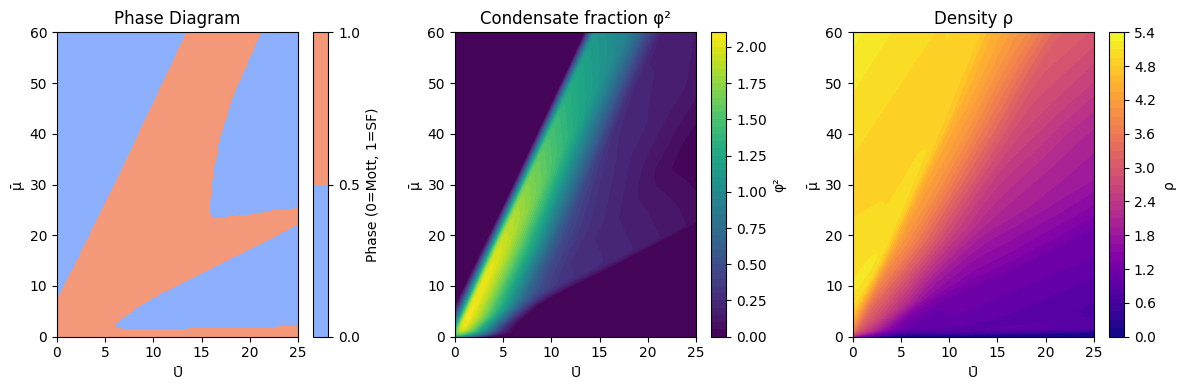

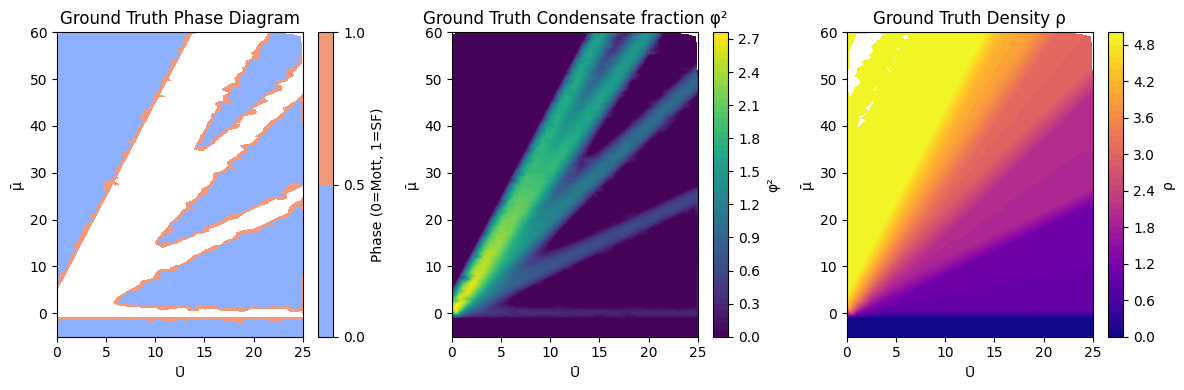

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid



# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)


df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])

df_reduced = df_reduced.reset_index(drop=True)

print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())
# Use reduced dataset
df = df_reduced.reset_index(drop=True)

print("Reduced dataset shape:", df.shape)

# pinn = make_pinn()
# pinn.fit(X, y, epochs=50, batch_size=256, validation_split=0.2)


# print( " Initial Data", df)


# Features: use Ubar and Mubar only
X = df[["Ubar", "Mubar"]].values

# Prepare multi-task targets
y_phase = df["Phase"].values
y_phi2  = df["Phi2"].values
y_rho   = df["Density"].values

# Split data
X_train, X_test, y_phase_train, y_phase_test, y_phi2_train, y_phi2_test, y_rho_train, y_rho_test = train_test_split(
    X, y_phase, y_phi2, y_rho, test_size=0.25, random_state=42, stratify=y_phase
)



def make_multitask_batch(input_dim=2, hidden=(64,64), dropout=0.2):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi2_out = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out = layers.Dense(1, activation="relu", name="rho")(x)

    model = keras.Model(inputs, [phase_out, phi2_out, rho_out])
    model.compile(
        optimizer="adam",
        loss={"phase":"binary_crossentropy", "phi2":"mse", "rho":"mse"},
        loss_weights={"phase":1.0, "phi2":0.5, "rho":0.5},
        metrics={"phase":"accuracy"}
    )
    return model
# Build model
multi_model = make_multitask_batch()
from sklearn.utils.class_weight import compute_sample_weight

# Compute per-sample weights for phase classification
phase_sample_weight = compute_sample_weight(
    class_weight="balanced",
    y=y_phase_train
)

# Create dict of sample weights (only phase gets weighting)
sample_weight_dict = {
    "phase": phase_sample_weight,
    "phi2": np.ones_like(y_phi2_train),
    "rho": np.ones_like(y_rho_train)
}



# history = model.fit(
#     X_train, {"phase": y_phase_train, "phi2": y_phi2_train, "rho": y_rho_train},
#     validation_data=(X_val, {"phase": y_phase_val, "phi2": y_phi2_val, "rho": y_rho_val}),
#     epochs=50,
#     batch_size=64,
#     class_weight={"phase": class_weights}
# )
# Train
# Train
history = multi_model.fit(
    X_train,
    [y_phase_train, y_phi2_train, y_rho_train],
    validation_data=(X_test, [y_phase_test, y_phi2_test, y_rho_test]),
    epochs=50,
    batch_size=64,
    verbose=1,
    sample_weight=[
        phase_sample_weight.astype(float),
        np.ones_like(y_phi2_train, dtype=float),
        np.ones_like(y_rho_train, dtype=float)
    ]
)



# Evaluate
results = multi_model.evaluate(
    X_test, {"phase": y_phase_test, "phi2": y_phi2_test, "rho": y_rho_test}
)
print("Evaluation:", results)




# Define grid in correct physics ranges
U_vals = np.linspace(0, 25, 200)   # x-axis
mu_vals = np.linspace(0, 60, 200)  # y-axis
UU, MU = np.meshgrid(U_vals, mu_vals)

X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1)

# Predict
phase_pred, phi2_pred, rho_pred =multi_model.predict(X_grid, verbose=0)

# Reshape
phase_pred = (phase_pred > 0.5).astype(int).reshape(UU.shape)
phi2_pred = phi2_pred.reshape(UU.shape)
rho_pred = rho_pred.reshape(UU.shape)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.contourf(UU, MU, phase_pred, levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Phase Diagram")

plt.subplot(1,3,2)
plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Density ρ")

plt.tight_layout()
plt.show()

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


In [16]:
def make_pinn(input_dim=2, hidden=(64,64), lam=1.0):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)
    
    # Outputs
    phi_out = layers.Dense(1, activation="relu", name="phi2")(x)  
    rho_out = layers.Dense(1, activation="relu", name="rho")(x)   
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)

    model = keras.Model(inputs, [phase_out, phi_out, rho_out])

    # Compile with dict of losses
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={
            "phase": 1.0,
            "phi2": lam,
            "rho": lam
        },
        metrics={"phase": "accuracy"}
    )

    return model

In [17]:
pinn = make_pinn()
history = pinn.fit(
    X,
    {"phase": y["phase"], "phi2": y["phi2"], "rho": y["rho"]},
    epochs=50,
    batch_size=256,
    validation_split=0.2
)


KeyError: 'phase'

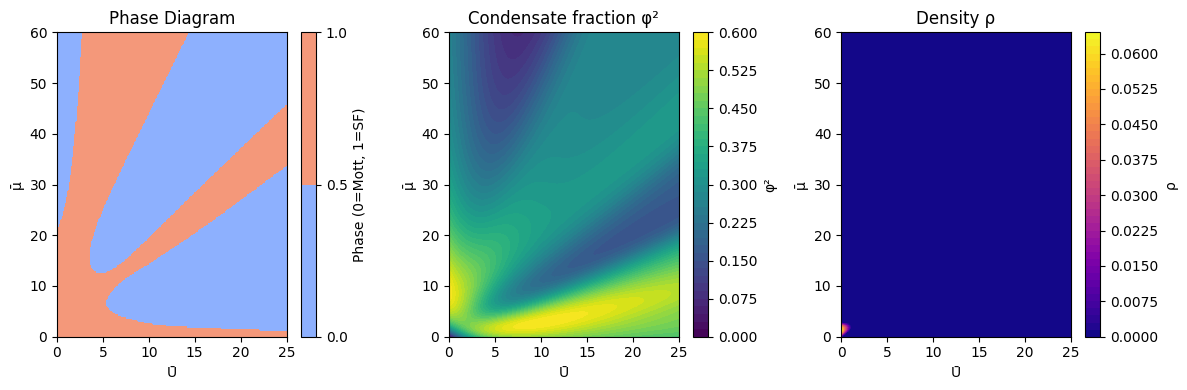

In [18]:
# Define grid in correct physics ranges
U_vals = np.linspace(0, 25, 200)   # x-axis
mu_vals = np.linspace(0, 60, 200)  # y-axis
UU, MU = np.meshgrid(U_vals, mu_vals)

X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1)

# Predict
phase_pred, phi2_pred, rho_pred = pinn.predict(X_grid, verbose=0)

# Reshape
phase_pred = (phase_pred > 0.5).astype(int).reshape(UU.shape)
phi2_pred = phi2_pred.reshape(UU.shape)
rho_pred = rho_pred.reshape(UU.shape)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.contourf(UU, MU, phase_pred, levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Phase Diagram")

plt.subplot(1,3,2)
plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Density ρ")

plt.tight_layout()
plt.show()


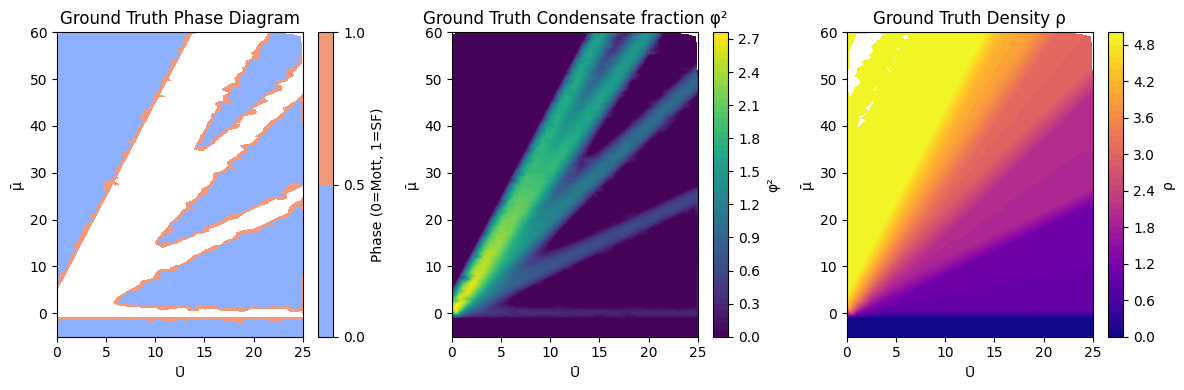

In [19]:
# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import classification_report

# Predict on the training set (or better, a separate test set)
y_pred_phase, y_pred_phi2, y_pred_rho = pinn.predict(X, verbose=0)

# Convert predicted probabilities into class labels
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()

# True labels
y_true_labels = y["phase"]

# Classification report
print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


KeyError: 'phase'

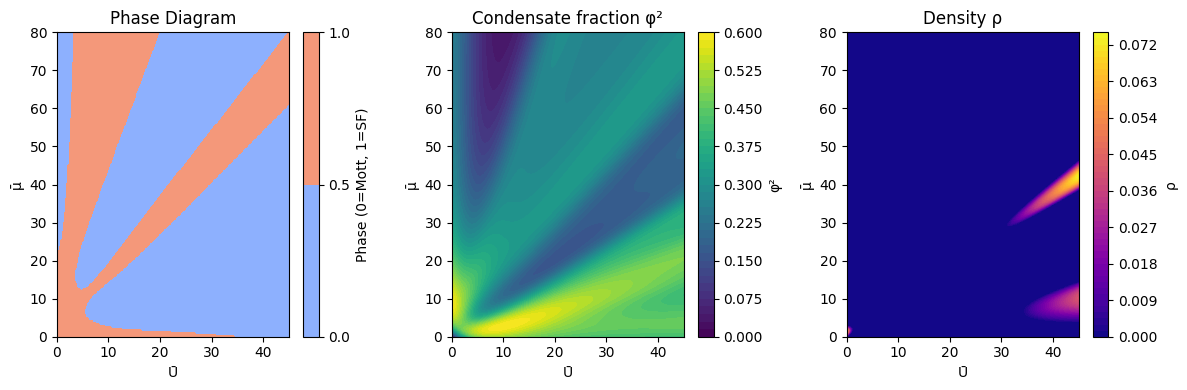

In [21]:
# Define grid in correct physics ranges
U_vals = np.linspace(0, 45, 200)   # x-axis
mu_vals = np.linspace(0, 80, 200)  # y-axis
UU, MU = np.meshgrid(U_vals, mu_vals)

X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1)

# Predict
phase_pred, phi2_pred, rho_pred = pinn.predict(X_grid, verbose=0)

# Reshape
phase_pred = (phase_pred > 0.5).astype(int).reshape(UU.shape)
phi2_pred = phi2_pred.reshape(UU.shape)
rho_pred = rho_pred.reshape(UU.shape)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.contourf(UU, MU, phase_pred, levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Phase Diagram")

plt.subplot(1,3,2)
plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Density ρ")

plt.tight_layout()
plt.show()


In [22]:
# def run_models_multi_output(
#     models, X, y,
#     U_min=0.0, U_max=15.0,
#     mu_min=0.0, mu_max=50.0,
#     U_step=0.1, mu_step=0.1
# ):
#     """
#     Run training, evaluation, decision boundary plotting, and prediction reports.
#     Handles both single-output classifiers and multi-output PINNs.
#     """

#     # Ensure X is DataFrame for plotting
#     if not isinstance(X, pd.DataFrame):
#         X = pd.DataFrame(X, columns=["Ubar", "Mubar"])

#     # Ensure y is series/dict properly
#     if isinstance(y, dict):
#         y_phase = y["phase"]
#     else:
#         y_phase = y

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y_phase,  # or y_multi
#         test_size=0.25, random_state=42,
#         stratify=None  # <- disable stratification for multi-output
#     )

#     # ---------- 1) Plot True phase diagram ----------
#     plt.figure(figsize=(9, 6))
#     plt.scatter(X["Ubar"], X["Mubar"], c=y_phase, s=10, cmap=ListedColormap(['blue','red']))
#     plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
#     plt.clim(-0.5, 1.5)
#     plt.xlabel("Ū"); plt.ylabel("μ̄")
#     plt.title("True Phase Diagram")
#     plt.grid(True)
#     plt.show()

#     # ---------- 2) Helper: decision boundary ----------
#     def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
#         x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
#         y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
#         x_min = max(0, x_min); y_min = max(0, y_min)

#         xx, yy = np.meshgrid(
#             np.linspace(x_min, x_max, grid_res),
#             np.linspace(y_min, y_max, grid_res)
#         )
#         grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})

#         Z = model.predict(grid_df)

#         # Handle PINN multi-output
#         if isinstance(Z, (list, tuple, dict)):
#             if isinstance(Z, dict):
#                 Z = Z["phase"]
#             else:
#                 Z = Z[0]
#         Z = (Z > 0.5).astype(int).reshape(xx.shape)

#         plt.figure(figsize=(9, 6))
#         plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray','orange']), alpha=0.5)

#         mask = X["Mubar"] >= 0
#         plt.scatter(
#             X.loc[mask, "Ubar"], X.loc[mask, "Mubar"],
#             c=y.loc[mask] if isinstance(y, pd.Series) else y[mask],
#             s=10, cmap=ListedColormap(['blue','red']),
#             edgecolor='k', linewidth=0.2
#         )
#         plt.colorbar(ticks=[0,1], label="Phase (0=Mott,1=SF)")
#         plt.clim(-0.5, 1.5)
#         plt.xlabel("Ū"); plt.ylabel("μ̄")
#         plt.title(title)
#         plt.grid(True)
#         plt.show()

#     # ---------- 3) Train + Evaluate ----------
#     for name, model in models.items():
#         print(f"\n🚀 Training {name}...")

#         # Keras multi-output needs dict
#         if isinstance(y, dict) and "phase" in y:
#             y_train_dict = {"phase": y["phase"][X_train.index],
#                             "phi2": y["phi2"][X_train.index],
#                             "rho":  y["rho"][X_train.index]}
#             model.fit(X_train, y_train_dict, epochs=50, batch_size=256, verbose=0,
#                       validation_split=0.2)
#         else:
#             model.fit(X_train, y_train)

#         # Predictions
#         y_pred = model.predict(X_test)
#         if isinstance(y_pred, (list, tuple, dict)):
#             if isinstance(y_pred, dict):
#                 y_pred = y_pred["phase"]
#             else:
#                 y_pred = y_pred[0]
#         y_pred = (y_pred > 0.5).astype(int)

#         print(f"\n📊 Classification Report for {name}:")
#         print(classification_report(y_test, y_pred, digits=4))

#         # Plot decision boundary
#         plot_decision_boundary(model, X, y_phase, title=f"{name}: Decision Boundary")

#         # Extended grid prediction (phase only)
#         U_vals = np.arange(U_min, U_max + U_step, U_step)
#         mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
#         U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
#         grid_ext = pd.DataFrame({"Ubar": U_grid.ravel(), "Mubar": mu_grid.ravel()})
#         pred_ext = model.predict(grid_ext)

#         if isinstance(pred_ext, (list, tuple, dict)):
#             if isinstance(pred_ext, dict):
#                 pred_ext = pred_ext["phase"]
#             else:
#                 pred_ext = pred_ext[0]
#         pred_ext = (pred_ext > 0.5).astype(int)
#         phase_map = pred_ext.reshape(U_grid.shape)

#         plt.figure(figsize=(9,6))
#         plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray','orange']), alpha=0.7)
#         plt.colorbar(ticks=[0,1], label="Phase (0=Mott,1=SF)")
#         plt.clim(-0.5, 1.5)
#         plt.xlabel("Ū"); plt.ylabel("μ̄")
#         plt.title(f"{name}: Predicted Phase Diagram")
#         plt.grid(True)
#         plt.show()
def run_models_multi_output(
    models, X, y,
    U_min=0.0, U_max=15.0,
    mu_min=0.0, mu_max=50.0,
    U_step=0.1, mu_step=0.1
):
    """
    Run training, evaluation, decision boundary plotting, and prediction reports.
    Handles both single-output classifiers and multi-output PINNs.
    """

    # Ensure X is DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=["Ubar", "Mubar"])

    # Decide phase labels
    if isinstance(y, dict):
        y_phase = y["phase"]
    elif isinstance(y, np.ndarray) and y.ndim > 1:
        y_phase = y[:, 0]
    else:
        y_phase = y

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=None
    )

    # ---------- 1) Plot True phase diagram ----------
    plt.figure(figsize=(9, 6))
    plt.scatter(X["Ubar"], X["Mubar"], c=y_phase, s=10,
                cmap=ListedColormap(['blue','red']))
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.xlabel("Ū"); plt.ylabel("μ̄")
    plt.title("True Phase Diagram")
    plt.grid(True)
    plt.show()

    # ---------- 2) Helper: decision boundary ----------
    def plot_decision_boundary(model, X, y_phase, title="Decision Boundary", grid_res=300):
        xx, yy = np.meshgrid(
            np.linspace(X["Ubar"].min(), X["Ubar"].max(), grid_res),
            np.linspace(X["Mubar"].min(), X["Mubar"].max(), grid_res)
        )
        grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})

        Z = model.predict(grid_df, verbose=0)

        if isinstance(Z, dict):
            Z = Z["phase"]
        elif isinstance(Z, (list, tuple)):
            Z = Z[0]

        Z = (Z > 0.5).astype(int).reshape(xx.shape)

        plt.figure(figsize=(9, 6))
        plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray','orange']), alpha=0.5)
        plt.scatter(X["Ubar"], X["Mubar"], c=y_phase, s=10,
                    cmap=ListedColormap(['blue','red']), edgecolor='k', linewidth=0.2)
        plt.colorbar(ticks=[0,1], label="Phase (0=Mott,1=SF)")
        plt.xlabel("Ū"); plt.ylabel("μ̄")
        plt.title(title)
        plt.grid(True)
        plt.show()

    # ---------- 3) Train + Evaluate ----------
    for name, model in models.items():
        print(f"\n🚀 Training {name}...")

        # Multi-output case
        if isinstance(y, dict):
            y_train_dict = {k: v[X_train.index] for k, v in y.items()}
            y_test_dict  = {k: v[X_test.index] for k, v in y.items()}
            model.fit(X_train, y_train_dict,
                      epochs=50, batch_size=256, verbose=0,
                      validation_split=0.2)
        elif isinstance(y_train, np.ndarray) and y_train.ndim > 1:
            # Assume col 0 = phase, col 1 = density
            y_train_dict = {
                "phase": y_train[:, 0].astype(int),
                "density": y_train[:, 1]
            }
            y_test_dict = {
                "phase": y_test[:, 0].astype(int),
                "density": y_test[:, 1]
            }
            model.fit(X_train, y_train_dict,
                      epochs=50, batch_size=256, verbose=0,
                      validation_split=0.2)
        else:
            # Single-output
            model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test, verbose=0)
        if isinstance(y_pred, dict):
            y_pred = y_pred["phase"]
        elif isinstance(y_pred, (list, tuple)):
            y_pred = y_pred[0]
        y_pred = (y_pred > 0.5).astype(int)

        # print(f"\n📊 Classification Report for {name}:")
        from sklearn.metrics import classification_report
        # y_true_phase = y_test if y_test.ndim == 1 else y_test[:,0]
        # print(classification_report(y_true_phase, y_pred, digits=4))

        # for i, name in enumerate(["Phase", "n", "m"]):
        #     y_true_i = y_test[:, i]
        #     y_pred_i = np.argmax(y_pred[:, i*2:(i+1)*2], axis=1)  # assuming 2 classes per output
        #     print(f"\n📊 Classification Report for {name}:")
        #     print(classification_report(y_true_i, y_pred_i, digits=4))

        for i, name in enumerate(["Phase", "n", "m"]):
            y_true_i = y_test[:, i]
            y_pred_i = y_pred[:, i]   # Already class labels
            print(f"\n📊 Classification Report for {name}:")
            print(classification_report(y_true_i, y_pred_i, digits=4))



        # Plot decision boundary
        plot_decision_boundary(model, X, y_phase, title=f"{name}: Decision Boundary")

# def run_models_multi_output(
#     models, X, y,
#     U_min=0.0, U_max=15.0,
#     mu_min=0.0, mu_max=50.0,
#     U_step=0.1, mu_step=0.1
# ):
#     """
#     Run training, evaluation, decision boundary plotting, and prediction reports.
#     Handles both single-output classifiers and multi-output PINNs.
#     """

#     # Ensure X is DataFrame for plotting
#     if not isinstance(X, pd.DataFrame):
#         X = pd.DataFrame(X, columns=["Ubar", "Mubar"])

#     # ----- Handle y formats -----
#     if isinstance(y, dict):  # dict of outputs
#         y_phase = y["phase"]
#     elif isinstance(y, np.ndarray) and y.ndim > 1:  # multi-output ndarray
#         y_phase = y[:, 0]  # assume first column = phase
#     else:  # single-output
#         y_phase = y

#     # Train/test split (disable stratify for multi-output)
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.25, random_state=42, stratify=None
#     )

#     # ---------- 1) Plot True phase diagram ----------
#     plt.figure(figsize=(9, 6))
#     plt.scatter(X["Ubar"], X["Mubar"], c=y_phase, s=10, cmap=ListedColormap(['blue','red']))
#     plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
#     plt.clim(-0.5, 1.5)
#     plt.xlabel("Ū"); plt.ylabel("μ̄")
#     plt.title("True Phase Diagram")
#     plt.grid(True)
#     plt.show()

#     # ---------- 2) Helper: decision boundary ----------
#     def plot_decision_boundary(model, X, y_phase, title="Decision Boundary", grid_res=300):
#         x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
#         y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
#         x_min = max(0, x_min); y_min = max(0, y_min)

#         xx, yy = np.meshgrid(
#             np.linspace(x_min, x_max, grid_res),
#             np.linspace(y_min, y_max, grid_res)
#         )
#         grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})

#         Z = model.predict(grid_df)

#         # Handle PINN multi-output
#         if isinstance(Z, (list, tuple, dict)):
#             if isinstance(Z, dict):
#                 Z = Z["phase"]
#             else:
#                 Z = Z[0]
#         Z = (Z > 0.5).astype(int).reshape(xx.shape)

#         plt.figure(figsize=(9, 6))
#         plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray','orange']), alpha=0.5)

#         mask = X["Mubar"] >= 0
#         plt.scatter(
#             X.loc[mask, "Ubar"], X.loc[mask, "Mubar"],
#             c=y_phase[mask] if not isinstance(y_phase, dict) else y_phase["phase"][mask],
#             s=10, cmap=ListedColormap(['blue','red']),
#             edgecolor='k', linewidth=0.2
#         )
#         plt.colorbar(ticks=[0,1], label="Phase (0=Mott,1=SF)")
#         plt.clim(-0.5, 1.5)
#         plt.xlabel("Ū"); plt.ylabel("μ̄")
#         plt.title(title)
#         plt.grid(True)
#         plt.show()

#     # ---------- 3) Train + Evaluate ----------
#     for name, model in models.items():
#         print(f"\n🚀 Training {name}...")

#         # Multi-output Keras
#         if isinstance(y, dict) and "phase" in y:
#             y_train_dict = {k: v[X_train.index] for k, v in y.items()}
#             model.fit(X_train, y_train_dict, epochs=50, batch_size=256, verbose=0,
#                       validation_split=0.2)
#         else:
#             model.fit(X_train, y_train)

#         # Predictions (phase only)
#         y_pred = model.predict(X_test)
#         if isinstance(y_pred, (list, tuple, dict)):
#             if isinstance(y_pred, dict):
#                 y_pred = y_pred["phase"]
#             else:
#                 y_pred = y_pred[0]
#         y_pred = (y_pred > 0.5).astype(int)

#         print(f"\n📊 Classification Report for {name}:")
#         print(classification_report(y_test if y_test.ndim==1 else y_test[:,0], y_pred, digits=4))

#         # Plot decision boundary
#         plot_decision_boundary(model, X, y_phase, title=f"{name}: Decision Boundary")

#         # Extended grid prediction (phase only)
#         U_vals = np.arange(U_min, U_max + U_step, U_step)
#         mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
#         U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
#         grid_ext = pd.DataFrame({"Ubar": U_grid.ravel(), "Mubar": mu_grid.ravel()})
#         pred_ext = model.predict(grid_ext)

#         if isinstance(pred_ext, (list, tuple, dict)):
#             if isinstance(pred_ext, dict):
#                 pred_ext = pred_ext["phase"]
#             else:
#                 pred_ext = pred_ext[0]
#         pred_ext = (pred_ext > 0.5).astype(int)
#         phase_map = pred_ext.reshape(U_grid.shape)

#         plt.figure(figsize=(9,6))
#         plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray','orange']), alpha=0.7)
#         plt.colorbar(ticks=[0,1], label="Phase (0=Mott,1=SF)")
#         plt.clim(-0.5, 1.5)
#         plt.xlabel("Ū"); plt.ylabel("μ̄")
#         plt.title(f"{name}: Predicted Phase Diagram")
#         plt.grid(True)
#         plt.show()


In [23]:
# Features and target: **only** Ubar, Mubar
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)

# Features and target
X = df[["Ubar", "Mubar"]].values
y_dict = {
    "phase": df["Phase"].values,
    "phi2": df["Phi2"].values,
    "rho": df["Density"].values
}
y_multi = np.column_stack([y_dict["phase"], y_dict["phi2"], y_dict["rho"]])

print(X)
print(y)
print(y_multi)

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

In [24]:
models = {
    "PINN-multi": make_pinn_multi()
}

run_models_multi_output(models, X, y_multi, U_max=25, mu_max=60)

NameError: name 'make_pinn_multi' is not defined

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def run_models_multi_output2(models, X, y_multi,
                            U_min=0, U_max=25, mu_min=0, mu_max=60,
                            U_step=0.2, mu_step=0.2):
    """
    Train and evaluate multi-output models (phase classification + other outputs).
    Models must be tf.keras.Model (not KerasClassifier).
    """
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_multi, test_size=0.2, random_state=42
    )

    # Build dictionary for outputs
    y_train_dict = {
        "phase": y_train[:, 0].astype(int),
        "density": y_train[:, 1]
    }
    y_test_dict = {
        "phase": y_test[:, 0].astype(int),
        "density": y_test[:, 1]
    }

    for name, model in models.items():
        print(f"🚀 Training {name}...")

        # Train
        history = model.fit(
            X_train, y_train_dict,
            epochs=50, batch_size=256,
            validation_split=0.2, verbose=0
        )

        # Predictions on grid for phase diagram
        U_vals = np.arange(U_min, U_max, U_step)
        mu_vals = np.arange(mu_min, mu_max, mu_step)
        U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
        X_grid = np.c_[U_grid.ravel(), mu_grid.ravel()]

        y_pred_phase, y_pred_density = model.predict(X_grid, verbose=0)
        y_pred_labels = np.argmax(y_pred_phase, axis=1).reshape(U_grid.shape)

        # Plot phase diagram
        plt.figure(figsize=(6, 5))
        plt.contourf(U_grid, mu_grid, y_pred_labels, levels=1, cmap="coolwarm", alpha=0.6)
        plt.colorbar(label="Predicted Phase")
        plt.xlabel("Ubar")
        plt.ylabel("Mubar")
        plt.title(f"Predicted Phase Diagram ({name})")
        plt.show()

        # Evaluate test set
        test_loss, phase_loss, density_loss, phase_acc, density_mse = model.evaluate(
            X_test, y_test_dict, verbose=0
        )
        print(f"{name} test phase acc = {phase_acc:.3f}, density mse = {density_mse:.3f}")


In [26]:
models = {
    "PINN-multi": make_pinn_multi()
}

run_models_multi_output2(models, X, y_multi, U_max=25, mu_max=60)


NameError: name 'make_pinn_multi' is not defined

In [27]:
y_dict = {
    "phase": y_multi[:, 0],    # first column is phase labels
    "density": y_multi[:, 1]   # second column is density values
}

model = make_pinn_multi()
history = model.fit(
    X, y_dict,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)


NameError: name 'make_pinn_multi' is not defined

In [28]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# def make_trueloss_pinn(input_dim=2, hidden=(64, 64), lam=1.0, lam_phys=0.1):
#     inputs = keras.Input(shape=(input_dim,))
#     x = inputs
#     for h in hidden:
#         x = layers.Dense(h, activation="tanh")(x)

#     # Outputs
#     phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
#     phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
#     rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

#     model = keras.Model(inputs, [phase_out, phi_out, rho_out])

#     # ---- Custom physics-informed loss ----
#     def physics_loss(y_true, y_pred):
#         # unpack predictions
#         phase_pred, phi_pred, rho_pred = y_pred

#         # Physics: enforce φ² ~ 0 for MI (phase=0), φ² > 0 for SF (phase=1)
#         phys_term = (1 - phase_pred) * phi_pred  # penalize φ² in Mott phase
#         return tf.reduce_mean(phys_term)

#     # ---- Wrapper to combine supervised + physics ----
#     def combined_loss(y_true, y_pred):
#         # supervised parts
#         phase_true, phi_true, rho_true = y_true
#         phase_pred, phi_pred, rho_pred = y_pred

#         # classification loss
#         sup_phase = keras.losses.binary_crossentropy(phase_true, phase_pred)
#         # regression losses
#         sup_phi = keras.losses.mse(phi_true, phi_pred)
#         sup_rho = keras.losses.mse(rho_true, rho_pred)

#         # physics loss
#         phys = physics_loss(None, (phase_pred, phi_pred, rho_pred))

#         return sup_phase + lam*(sup_phi + sup_rho) + lam_phys*phys

#     # Compile with wrapper
#     model.compile(
#         optimizer=keras.optimizers.Adam(),
#         loss=combined_loss,
#         metrics={"phase": "accuracy"}
#     )

#     return model

import keras
from keras import layers
from keras.layers import Input, Dense, Lambda

def make_trueloss_pinn(input_dim=10, hidden=64, lam=1.0, lam_phys=0.1):
    # Input
    inp = Input(shape=(input_dim,), name="input")

    # Shared hidden layers
    x = inp
    for _ in range(3):
        x = Dense(hidden, activation="tanh")(x)

    # Output heads
    phase_out = Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = Dense(1, activation="linear", name="phi2")(x)
    rho_out   = Dense(1, activation="linear", name="rho")(x)

    # Physics-informed output (no label needed, we'll feed dummy zeros)
    def physics_loss_layer(inputs):
        phase_pred, phi_pred = inputs
        return (1.0 - phase_pred) * phi_pred

    physics_out = Lambda(physics_loss_layer, name="physics")([phase_out, phi_out])

    # Build model with 4 outputs
    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, physics_out])

    # Compile with multiple losses
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse",
            "physics": lambda y_true, y_pred: lam_phys * keras.ops.mean(y_pred),
        },
        loss_weights={"phase": lam, "phi2": 1.0, "rho": 1.0, "physics": 1.0},
        metrics={"phase": "accuracy"},
    )

    return model


In [29]:
# Features and target: **only** Ubar, Mubar
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)

# Features and target
X = df[["Ubar", "Mubar"]].values
y = {
    "phase": df["Phase"].values,
    "phi2": df["Phi2"].values,
    "rho": df["Density"].values
}

print(X)
print(y)

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

In [30]:
true_pinn = make_trueloss_pinn(input_dim=X.shape[1])

history = true_pinn.fit(
    X,
    {
        "phase": y["phase"],
        "phi2": y["phi2"],
        "rho": y["rho"],
        "physics": np.zeros((len(X), 1)),  # dummy labels for physics head
    },
    epochs=50,
    batch_size=256,
    validation_split=0.2,
)



Epoch 1/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6997 - phase_accuracy: 0.8460 - phase_loss: 0.3532 - phi2_loss: 0.1460 - physics_loss: 0.0090 - rho_loss: 0.1912 - val_loss: 0.4723 - val_phase_accuracy: 0.7580 - val_phase_loss: 0.3856 - val_phi2_loss: 0.0556 - val_physics_loss: -4.4169e-04 - val_rho_loss: 0.0328
Epoch 2/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1856 - phase_accuracy: 0.9503 - phase_loss: 0.1297 - phi2_loss: 0.0439 - physics_loss: 1.7355e-04 - rho_loss: 0.0119 - val_loss: 0.2419 - val_phase_accuracy: 0.9139 - val_phase_loss: 0.1815 - val_phi2_loss: 0.0378 - val_physics_loss: 0.0010 - val_rho_loss: 0.0229
Epoch 3/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0949 - phase_accuracy: 0.9782 - phase_loss: 0.0631 - phi2_loss: 0.0263 - physics_loss: -0.0016 - rho_loss: 0.0070 - val_loss: 0.1456 - val_phase_accuracy: 0.9501 - val_phase_loss: 0.1051 - val_phi2_loss: 0.0267 - val_physics_loss: -0.0017 - val_rho_loss: 0.0164
Epoch 4/50
511/511 ━━━

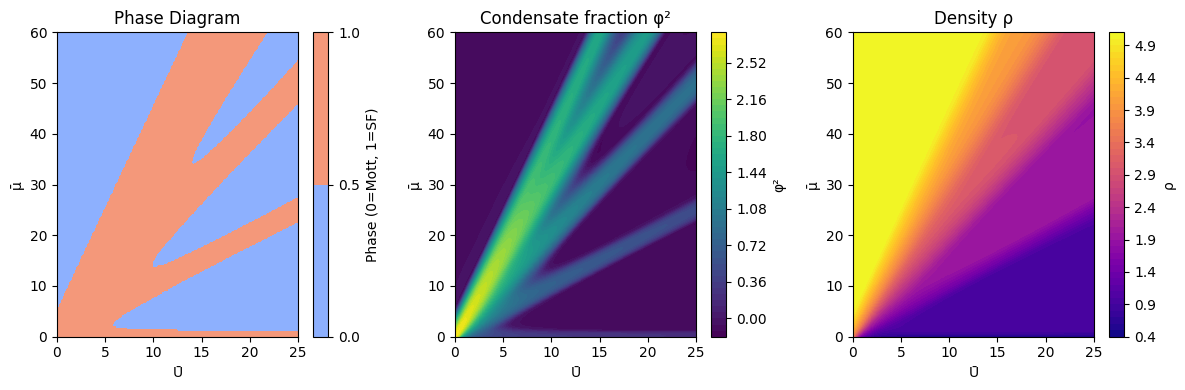

In [31]:
U_vals = np.linspace(0, 25, 200)   # x-axis (Ū range)
mu_vals = np.linspace(0, 60, 200)  # y-axis (μ̄ range)
UU, MU = np.meshgrid(U_vals, mu_vals)

X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1)


# Predict → model has 4 outputs: [phase, phi2, rho, physics]
y_pred_grid = true_pinn.predict(X_grid, verbose=0)

# Unpack only first three
phase_pred, phi2_pred, rho_pred = y_pred_grid[:3]

# Reshape each to match grid
phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)

# Threshold classification for phase diagram
phase_pred_class = (phase_pred > 0.5).astype(int)

# ---------- Plot ----------
plt.figure(figsize=(12,4))

# Phase diagram
plt.subplot(1,3,1)
plt.contourf(UU, MU, phase_pred_class, levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Phase Diagram")

# Condensate fraction φ²
plt.subplot(1,3,2)
plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Condensate fraction φ²")

# Density ρ
plt.subplot(1,3,3)
plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Density ρ")

plt.tight_layout()
plt.show()


In [32]:
# Predict on training (or test) set
y_pred_phase, y_pred_phi2, y_pred_rho, _ = true_pinn.predict(X, verbose=0)

# Convert probabilities → labels
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()

# True labels (same length as X) 
y_true_labels = y["phase"]

# Report
print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9962    0.9910    0.9936     97450
           1     0.9868    0.9943    0.9906     65951

    accuracy                         0.9924    163401
   macro avg     0.9915    0.9927    0.9921    163401
weighted avg     0.9924    0.9924    0.9924    163401



## Train a surrogate model (keras)

In [33]:
# --- prepare training data (you already have df) ---
import numpy as np, pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

# assume df has columns 'Ubar','Mubar','Phi2','Density'
X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

surrogate = build_surrogate()
surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512, validation_split=0.15, verbose=1)
# Save it for reuse
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)



Epoch 1/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7288 - val_loss: 0.1064
Epoch 2/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1031 - val_loss: 0.0778
Epoch 3/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0362 - val_loss: 0.0443
Epoch 4/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0191 - val_loss: 0.0178
Epoch 5/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 6/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0108 - val_loss: 0.0112
Epoch 7/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - val_loss: 0.0104
Epoch 8/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.0097
Epoch 9/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 10/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 11/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 12/200
272/272 ━━━━━━━━━━━━━━━━━━━━

In [34]:
# small sanity
pred = surrogate.predict(X_surr[:5])
print("true -> pred", y_surr[:5], pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
true -> pred [[1.0485760e-14 1.0485760e-14]
 [1.5084488e-14 1.5084488e-14]
 [2.1863401e-14 2.1863401e-14]
 [3.1937326e-14 3.1937326e-14]
 [4.7034771e-14 4.7034771e-14]] [[-0.02720144  0.0022981 ]
 [-0.02884677  0.00212   ]
 [-0.03049126  0.00194071]
 [-0.03213647  0.00176166]
 [-0.03378012  0.00158297]]


## PINN using surrogate as physical loss

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# load surrogate (or use the one in memory)
# surrogate = keras.models.load_model("surrogate_phi_rho.h5")
surrogate.trainable = False   # freeze surrogate

def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate: use Lambda layer to compute surr(U,M)
    def phys_residual(inputs):
        # inputs is batch of [Ubar,Mubar, phi_pred, rho_pred, phase_pred]
        UMb, phi_pred = inputs[0], inputs[1]
        # surrogate returns shape (batch,2)
        s = surrogate(UMb)                      # tf.Tensor (batch, 2)
        s_phi = tf.expand_dims(s[:, 0], -1)     # (batch,1)
        # residual: phi_pred - s_phi
        return phi_pred - s_phi

    # Build a small physics layer that takes inp and phi_out
    phys_out = layers.Lambda(lambda t: phys_residual([t[0], t[1]]), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    # losses: phase BCE, phi mse, rho mse, physics residual -> we match physics to zero
    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=losses, loss_weights=loss_weights, metrics={"phase":"accuracy"})
    return model

pinn_surrogate = make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0)

# prepare targets: phase, phi2, rho and zeros for physics residual
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}

history = pinn_surrogate.fit(
    df[["Ubar","Mubar"]].values.astype(np.float32),
    y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5), keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)]
)


Epoch 1/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6298 - phase_accuracy: 0.8380 - phase_loss: 0.3622 - phi2_loss: 0.0902 - phys_res_loss: 0.0919 - rho_loss: 0.0851 - val_loss: 0.5283 - val_phase_accuracy: 0.7761 - val_phase_loss: 0.4157 - val_phi2_loss: 0.0384 - val_phys_res_loss: 0.0359 - val_rho_loss: 0.0390 - learning_rate: 0.0010
Epoch 2/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2687 - phase_accuracy: 0.9239 - phase_loss: 0.1840 - phi2_loss: 0.0372 - phys_res_loss: 0.0378 - rho_loss: 0.0097 - val_loss: 0.3043 - val_phase_accuracy: 0.8577 - val_phase_loss: 0.2331 - val_phi2_loss: 0.0238 - val_phys_res_loss: 0.0232 - val_rho_loss: 0.0252 - learning_rate: 0.0010
Epoch 3/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1429 - phase_accuracy: 0.9730 - phase_loss: 0.1019 - phi2_loss: 0.0173 - phys_res_loss: 0.0176 - rho_loss: 0.0060 - val_loss: 0.1802 - val_phase_accuracy: 0.9506 - val_phase_loss: 0.1338 - val_phi2_loss: 0.0154 - val_phys_res_loss: 0.0155 

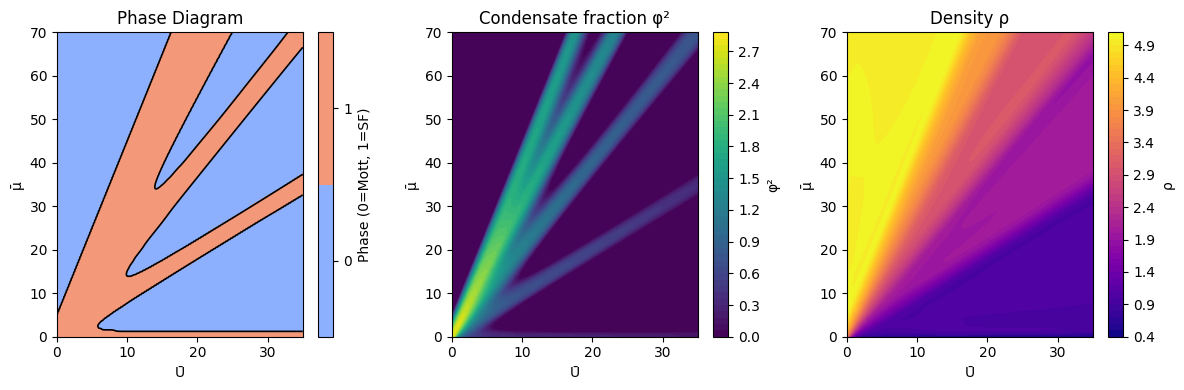

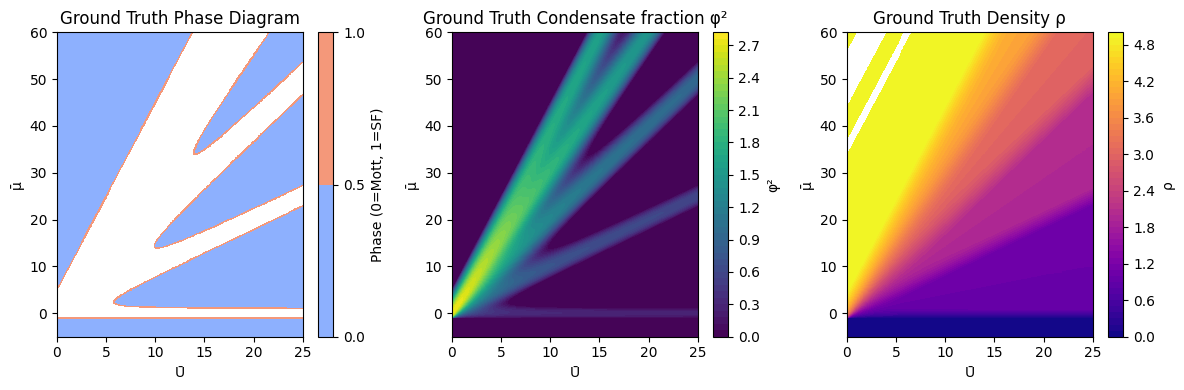

In [38]:
# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 35, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Diagram")

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


Epoch 1/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0171 - val_loss: 0.0864
Epoch 2/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0806 - val_loss: 0.0609
Epoch 3/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0331 - val_loss: 0.0439
Epoch 4/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0216 - val_loss: 0.0414
Epoch 5/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0216
Epoch 6/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 - val_loss: 0.0175
Epoch 7/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105 - val_loss: 0.0155
Epoch 8/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095 - val_loss: 0.0136
Epoch 9/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 - val_loss: 0.0151
Epoch 10/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084 - val_loss: 0.0122
Epoch 11/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - val_loss: 0.0111
Epoch 12/200
272/272 ━━━━━━━━━━━━━━━━━━━━

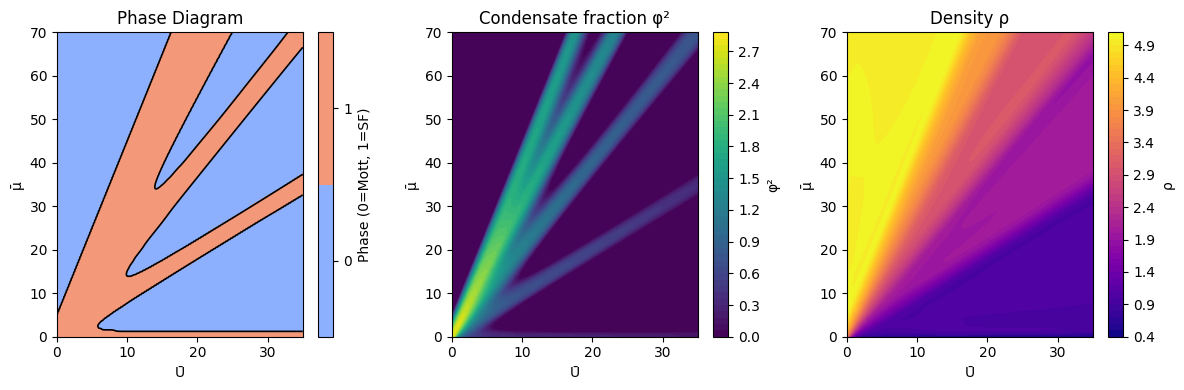

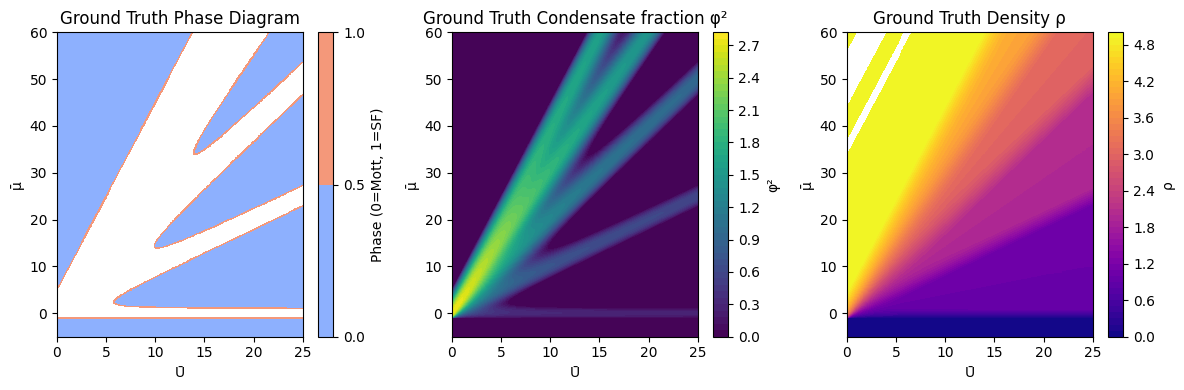


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9957    0.9994    0.9975     97450
           1     0.9991    0.9936    0.9964     65951

    accuracy                         0.9971    163401
   macro avg     0.9974    0.9965    0.9970    163401
weighted avg     0.9971    0.9971    0.9971    163401



C:\Users\DELL\AppData\Local\Temp\ipykernel_20628\3536766906.py:192: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [37]:
# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load dataset
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label phase: 1 = SF, 0 = MI
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}

history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    ]
)

# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 35, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Diagram")

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


## Same PINN+Surrogate model but we are trying to  validate our loss reference model is good enough

In [39]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


Epoch 1/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9294 - val_loss: 0.0997
Epoch 2/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0911 - val_loss: 0.0476
Epoch 3/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0294 - val_loss: 0.0397
Epoch 4/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0191 - val_loss: 0.0323
Epoch 5/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0231
Epoch 6/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0205
Epoch 7/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0159
Epoch 8/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0106 - val_loss: 0.0148
Epoch 9/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0099 - val_loss: 0.0147
Epoch 10/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094 - val_loss: 0.0125
Epoch 11/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - val_loss: 0.0124
Epoch 12/200
272/272 ━━━━━━━━━━━━━━━━━━━━

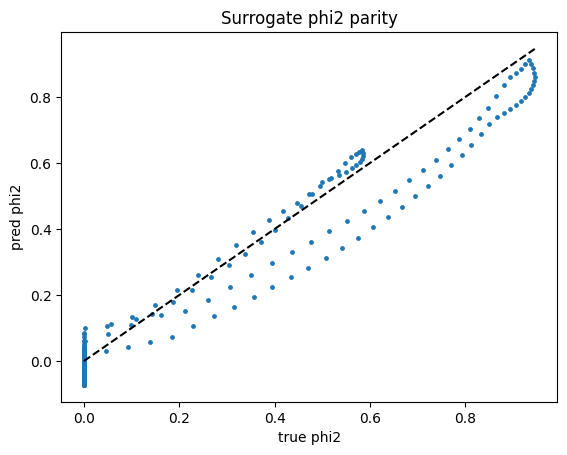

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6839 - phase_accuracy: 0.8234 - phase_loss: 0.3915 - phi2_loss: 0.1075 - phys_res_loss: 0.1064 - rho_loss: 0.0781 - val_loss: 0.5511 - val_phase_accuracy: 0.7686 - val_phase_loss: 0.4454 - val_phi2_loss: 0.0409 - val_phys_res_loss: 0.0388 - val_rho_loss: 0.0269 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2964 - phase_accuracy: 0.9080 - phase_loss: 0.2074 - phi2_loss: 0.0401 - phys_res_loss: 0.0390 - rho_loss: 0.0098 - val_loss: 0.3684 - val_phase_accuracy: 0.8464 - val_phase_loss: 0.2979 - val_phi2_loss: 0.0271 - val_phys_res_loss: 0.0255 - val_rho_loss: 0.0191 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1694 - phase_accuracy: 0.9623 - phase_loss: 0.1231 - phi2_loss: 0.0202 - phys_res_loss: 0.0196 - rho_loss: 0.0064 - val_loss: 0.1985 -

In [40]:
# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load dataset
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label phase: 1 = SF, 0 = MI
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb,
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    ]
)



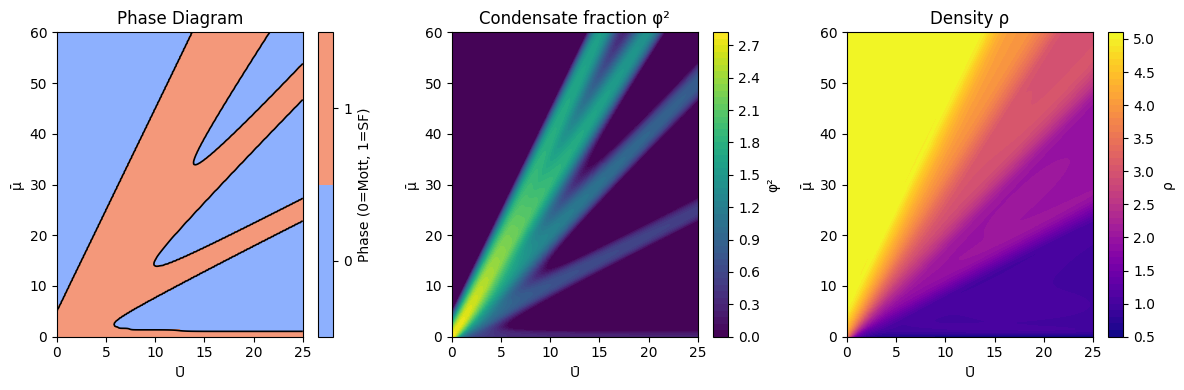

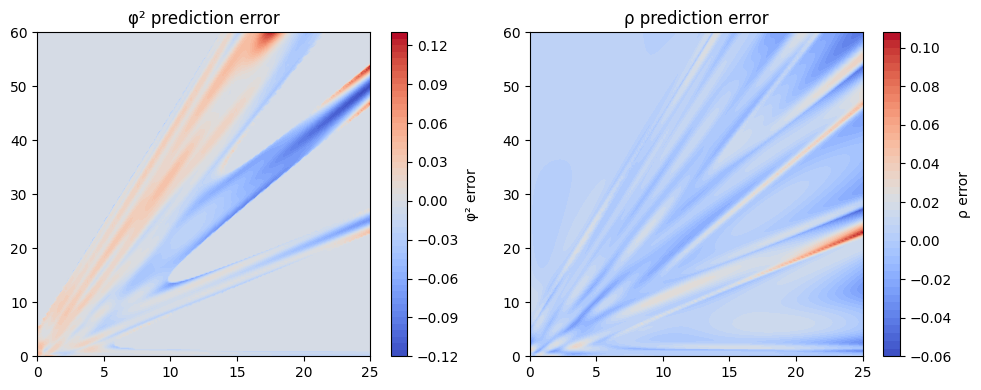

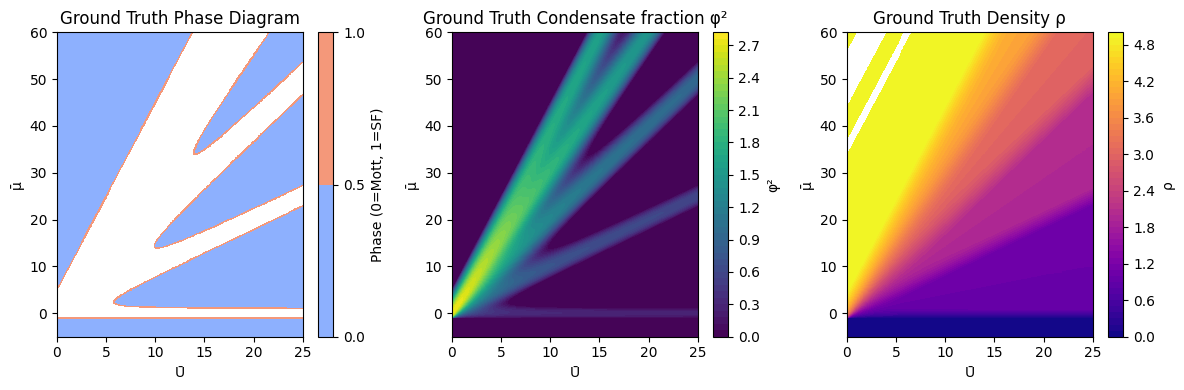


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9958    0.9994    0.9976     97450
           1     0.9992    0.9938    0.9965     65951

    accuracy                         0.9972    163401
   macro avg     0.9975    0.9966    0.9970    163401
weighted avg     0.9972    0.9972    0.9972    163401



C:\Users\DELL\AppData\Local\Temp\ipykernel_20628\2991935851.py:106: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [41]:
# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Diagram")

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)

# True values
y_true_phi2 = df["Phi2"].values
y_true_rho  = df["Density"].values

# Regression metrics
print("\n📊 Regression Report (Phi²):")
print("MAE :", mean_absolute_error(y_true_phi2, y_pred_phi2))
print("RMSE:", np.sqrt(mean_squared_error(y_true_phi2, y_pred_phi2)))
print("R²  :", r2_score(y_true_phi2, y_pred_phi2))

print("\n📊 Regression Report (Density):")
print("MAE :", mean_absolute_error(y_true_rho, y_pred_rho))
print("RMSE:", np.sqrt(mean_squared_error(y_true_rho, y_pred_rho)))
print("R²  :", r2_score(y_true_rho, y_pred_rho))



📊 Regression Report (Phi²):
MAE : 0.009271162571134046
RMSE: 0.020431042964789314
R²  : 0.9989858104197731

📊 Regression Report (Density):
MAE : 0.007388213470347686
RMSE: 0.010751491859297422
R²  : 0.9999577883659959


In [43]:
print(df)

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

In [44]:
# Example: 3 bins for Density
bins_density = np.linspace(y_true_rho.min(), y_true_rho.max(), 4)
y_true_rho_bins = np.digitize(y_true_rho, bins_density)
y_pred_rho_bins = np.digitize(y_pred_rho.ravel(), bins_density)

print("\n📊 Classification-style Report (Binned Density):")
print(classification_report(y_true_rho_bins, y_pred_rho_bins, digits=4))



📊 Classification-style Report (Binned Density):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.9993    0.7695    0.8695     45157
           2     0.9973    0.9990    0.9982     54948
           3     0.9987    0.4551    0.6253     56785
           4     0.1740    1.0000    0.2964      6511

    accuracy                         0.7466    163401
   macro avg     0.6339    0.6447    0.5579    163401
weighted avg     0.9656    0.7466    0.8051    163401



C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731:

## Reduction of dataset 

In [45]:
import numpy as np, pandas as pd

# --- 1) Load dataset ---
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Phase label
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# --- 2) Extreme points ---
extreme_points = df[
    (df["Ubar"].isin([df["Ubar"].min(), df["Ubar"].max()])) |
    (df["Mubar"].isin([df["Mubar"].min(), df["Mubar"].max()]))
]

# --- 3) Curvature-based points ---
df = df.sort_values(["Ubar","Mubar"])  # make sure sorted
df["dDensity_dMu"] = df.groupby("Ubar")["Density"].diff().abs()
df["dPhi2_dMu"] = df.groupby("Ubar")["Phi2"].diff().abs()

thr_density = df["dDensity_dMu"].quantile(0.9)
thr_phi2 = df["dPhi2_dMu"].quantile(0.9)

curvature_points = df[
    (df["dDensity_dMu"] > thr_density) |
    (df["dPhi2_dMu"] > thr_phi2)
]

# --- 4) Flat region subsample ---
flat_points = df.drop(curvature_points.index).sample(frac=0.02, random_state=42)

# --- 5) Merge reduced dataset ---
reduced_df = pd.concat([extreme_points, curvature_points, flat_points]).drop_duplicates()
print("Full dataset size   :", len(df))
print("Reduced dataset size:", len(reduced_df))

# --- 6) Features + Targets ---
X_reduced = reduced_df[["Ubar","Mubar"]].values.astype(np.float32)
y_reduced = {
    "phase": reduced_df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  reduced_df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   reduced_df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(reduced_df),1), dtype=np.float32)
}

# --- 7) Train PINN on reduced dataset ---
history_reduced = pinn_surrogate.fit(
    X_reduced, y_reduced,
    batch_size=128, epochs=200, validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    ]
)

# --- 8) Evaluate on full dataset ---
X_full = df[["Ubar","Mubar"]].values.astype(np.float32)
y_true_phase = df["Phase"].values.astype(int).ravel()
y_true_phi2  = df["Phi2"].values.astype(float).ravel()
y_true_rho   = df["Density"].values.astype(float).ravel()

y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X_full, verbose=0)

# --- Phase classification report ---
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_phase, (y_pred_phase > 0.5).astype(int).ravel(), digits=4))

# --- Phi² regression ---
mae_phi = mean_absolute_error(y_true_phi2, y_pred_phi2)
rmse_phi = np.sqrt(mean_squared_error(y_true_phi2, y_pred_phi2))

r2_phi = r2_score(y_true_phi2, y_pred_phi2)

print("\n📊 Regression Report (Phi²):")
print("MAE :", mae_phi)
print("RMSE:", rmse_phi)
print("R²  :", r2_phi)

# --- Density regression ---
mae_rho = mean_absolute_error(y_true_rho, y_pred_rho)
rmse_rho = np.sqrt(mean_squared_error(y_true_rho, y_pred_rho))
r2_rho = r2_score(y_true_rho, y_pred_rho)

print("\n📊 Regression Report (Density):")
print("MAE :", mae_rho)
print("RMSE:", rmse_rho)
print("R²  :", r2_rho)


Full dataset size   : 163401
Reduced dataset size: 32094
Epoch 1/200
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - phase_accuracy: 0.9979 - phase_loss: 0.0057 - phi2_loss: 3.5701e-04 - phys_res_loss: 6.6748e-04 - rho_loss: 1.7687e-04 - val_loss: 0.0256 - val_phase_accuracy: 0.9919 - val_phase_loss: 0.0220 - val_phi2_loss: 5.9532e-04 - val_phys_res_loss: 0.0023 - val_rho_loss: 4.2614e-04 - learning_rate: 1.5625e-05
Epoch 2/200
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - phase_accuracy: 0.9981 - phase_loss: 0.0052 - phi2_loss: 3.2225e-04 - phys_res_loss: 5.7420e-04 - rho_loss: 1.4512e-04 - val_loss: 0.0254 - val_phase_accuracy: 0.9915 - val_phase_loss: 0.0219 - val_phi2_loss: 5.6302e-04 - val_phys_res_loss: 0.0023 - val_rho_loss: 3.8758e-04 - learning_rate: 1.5625e-05
Epoch 3/200
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - phase_accuracy: 0.9981 - phase_loss: 0.0051 - phi2_loss: 3.1651e-04 - phys_res_loss: 5.6206e-04 - rho_loss: 1.3669e-04 - val_lo

In [46]:
import numpy as np
import pandas as pd

def make_reduced_df(df, num_points=200, transition_region=(4, 8), target_col="Phi2"):
    """
    Reduce dataset while keeping physics-important points.
    Returns a new DataFrame.
    """
    U_vals = df["Ubar"].values
    target = df[target_col].values
    N = len(df)

    keep_idx = []

    # 1. Extremes
    keep_idx.extend([0, N-1])

    # 2. Transition region
    transition_mask = (U_vals >= transition_region[0]) & (U_vals <= transition_region[1])
    keep_idx.extend(list(np.where(transition_mask)[0]))

    # 3. Curvature (based on Phi2 by default)
    dydU = np.gradient(target, U_vals)
    d2ydU2 = np.gradient(dydU, U_vals)
    high_curv_idx = np.argsort(np.abs(d2ydU2))[-10:]
    keep_idx.extend(list(high_curv_idx))

    # 4. Uniform subsample of the rest
    keep_idx = sorted(set(keep_idx))
    if len(keep_idx) < num_points:
        extra_idx = np.linspace(0, N-1, num_points - len(keep_idx), dtype=int)
        keep_idx.extend(list(extra_idx))

    keep_idx = sorted(set(keep_idx))

    # Build reduced df
    reduced_df = df.iloc[keep_idx].reset_index(drop=True)
    return reduced_df

# ---- Example usage ----
reduced_df = make_reduced_df(df, num_points=1000, transition_region=(4, 8))

print("Full dataset size:", len(df))
print("Reduced dataset size:", len(reduced_df))
reduced_df.head()


Full dataset size: 163401
Reduced dataset size: 26702


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:1307: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:1307: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:1308: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:1308: RuntimeWarning: invalid value encoun

,t,Ubar,Mubar,Density,Phi2,Energy,Iters,Phase,dDensity_dMu,dPhi2_dMu
0,1.0,0.0,-5.0,1.048576e-14,1.048576e-14,2.097152e-13,8,0,NaN,NaN
1,1.0,4.0,-5.0,1.046584e-14,1.046584e-14,2.093168e-13,8,0,NaN,NaN
2,1.0,4.0,-4.9,1.505417e-14,1.505417e-14,2.876852e-13,8,0,4.588329e-15,4.588329e-15
3,1.0,4.0,-4.8,2.181686e-14,2.181686e-14,3.979394e-13,8,0,6.762687e-15,6.762687e-15
4,1.0,4.0,-4.7,3.186522e-14,3.186522e-14,5.541362e-13,8,0,1.004837e-14,1.004837e-14


          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

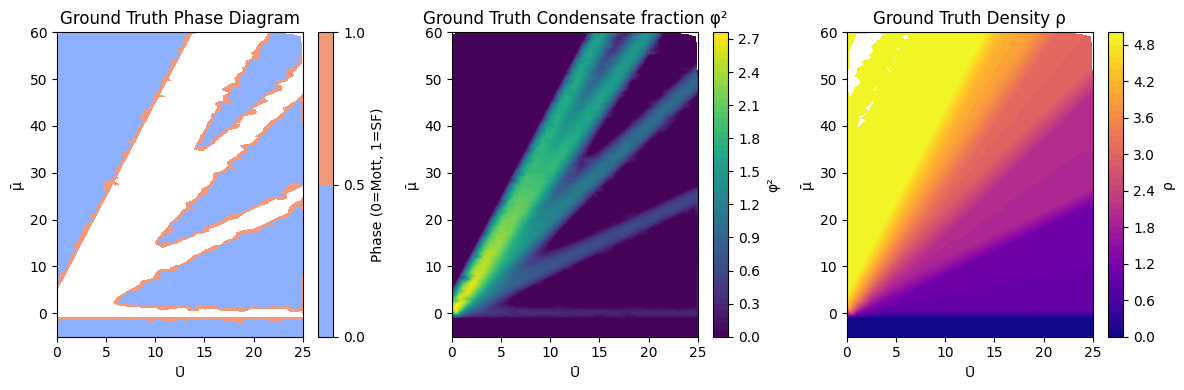

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


In [50]:
# --- 6) Classification report on FULL dataset ---
df_full = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")
df_full["Phase"] = df_full.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

X_full = df_full[["Ubar","Mubar"]].values.astype(np.float32)
y_true_full = df_full["Phase"].astype(int).ravel()

# Predict with trained model
y_pred_phase_full, _, _, _ = pinn_surrogate.predict(X_full, verbose=0)
y_pred_labels_full = (y_pred_phase_full > 0.5).astype(int).ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, FULL dataset):")
print(classification_report(y_true_full, y_pred_labels_full, digits=4))


C:\Users\DELL\AppData\Local\Temp\ipykernel_20628\2029224708.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_full = df_full["Phase"].astype(int).ravel()



📊 Classification Report (Phase, FULL dataset):
              precision    recall  f1-score   support

           0     0.9898    0.9752    0.9824     97450
           1     0.9641    0.9851    0.9745     65951

    accuracy                         0.9792    163401
   macro avg     0.9769    0.9801    0.9784    163401
weighted avg     0.9794    0.9792    0.9792    163401



        t  Ubar  Mubar       Density          Phi2        Energy  Iters  Phase
0     1.0  24.4   13.4  1.000000e+00  6.034134e-14 -1.340000e+01      9      0
1     1.0  16.0   -1.1  8.624612e-11  8.624612e-11  9.487073e-12    101      0
2     1.0  22.4    6.0  1.000000e+00  5.328648e-14 -6.000000e+00     10      0
3     1.0  14.2   22.4  2.000000e+00  6.649626e-12 -3.060000e+01     37      0
4     1.0  22.0    7.5  1.000000e+00  1.363996e-14 -7.500000e+00     10      0
...   ...   ...    ...           ...           ...           ...    ...    ...
4679  1.0   3.6   -1.0  8.456767e-05  8.456471e-05  4.598585e-09   4589      1
4680  1.0   5.3   26.2  4.999955e+00  2.254263e-04 -7.800000e+01   7465      1
4681  1.0  10.9   17.5  2.000244e+00  2.100670e-03 -2.410000e+01   2451      1
4682  1.0  16.3   -1.0  6.803388e-05  6.803021e-05  4.123775e-09   4118      1
4683  1.0   5.1   25.4  4.999955e+00  2.261209e-04 -7.600000e+01   7477      1

[4684 rows x 8 columns]
Epoch 1/200
8/8 ━━━━━━━━━━━

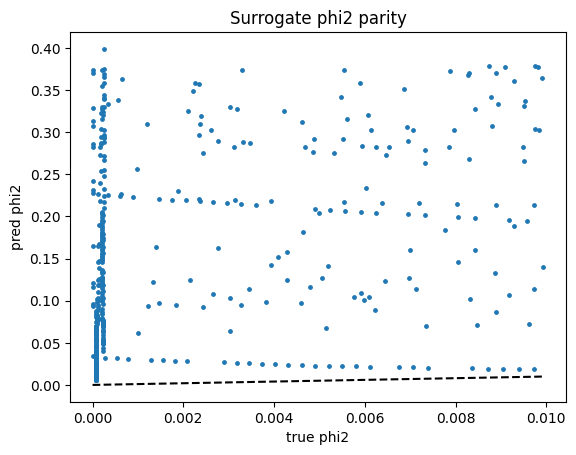

Epoch 0: lam_phys_current=0.000000
Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.3271 - phase_accuracy: 0.5544 - phase_loss: 0.6930 - phi2_loss: 0.4793 - phys_res_loss: 0.4558 - rho_loss: 1.6711 - val_loss: 1.5939 - val_phase_accuracy: 0.4253 - val_phase_loss: 0.7964 - val_phi2_loss: 0.1484 - val_phys_res_loss: 0.0741 - val_rho_loss: 0.5747 - learning_rate: 0.0010
Epoch 1: lam_phys_current=0.000000
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7708 - phase_accuracy: 0.6792 - phase_loss: 0.6476 - phi2_loss: 0.3314 - phys_res_loss: 0.3055 - rho_loss: 0.4793 - val_loss: 1.4400 - val_phase_accuracy: 0.3997 - val_phase_loss: 0.8464 - val_phi2_loss: 0.1994 - val_phys_res_loss: 0.1029 - val_rho_loss: 0.2914 - learning_rate: 0.0010
Epoch 2: lam_phys_current=0.000000
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2727 - phase_accuracy: 0.6868 - phase_loss: 0.6195 - phi2_loss: 0.2598 - phys_res_loss: 0.2312 - rho_loss: 0.1607 - val_loss: 1.3156 - val_

In [52]:
# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Train surrogate model ---
def build_surrogate(hidden=(128,64)):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)   # [phi2, rho]
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

surrogate = build_surrogate()
surrogate.fit(
    X_surr, y_surr,
    epochs=200, batch_size=512,
    validation_split=0.15, verbose=1
)

# Surrogate validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_val = X_surr[-500:]   # or better: shuffle and split properly
y_val = y_surr[-500:]
y_pred = surrogate.predict(X_val)
print("Surrogate MSE:", mean_squared_error(y_val, y_pred))
print("Surrogate MAE:", mean_absolute_error(y_val, y_pred))

# parity plot
import matplotlib.pyplot as plt
plt.scatter(y_val[:,0], y_pred[:,0], s=6); plt.xlabel("true phi2"); plt.ylabel("pred phi2"); plt.title("Surrogate phi2 parity")
plt.plot([y_val[:,0].min(), y_val[:,0].max()],[y_val[:,0].min(), y_val[:,0].max()], 'k--'); plt.show()


# Save & reload in new Keras format
surrogate.save("surrogate_phi_rho.keras")
surrogate = keras.models.load_model("surrogate_phi_rho.keras", compile=False)
surrogate.trainable = False   # freeze surrogate

# --- 3) PINN with surrogate residual ---
def make_pinn_with_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual via surrogate
    def phys_residual(inputs):
        UMb, phi_pred = inputs[0], inputs[1]
        s = surrogate(UMb)                  # surrogate predictions [phi2, rho]
        s_phi = tf.expand_dims(s[:, 0], -1) # only phi2
        return phi_pred - s_phi

    phys_out = layers.Lambda(
        lambda t: phys_residual([t[0], t[1]]),
        name="phys_res"
    )([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_surrogate = make_pinn_with_surrogate()

# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
    "phys_res": np.zeros((len(df),1), dtype=np.float32)
}


def mc_predict(model, X, n=50):
    preds = []
    for _ in range(n):
        p = model(X, training=True)  # keep dropout active
        preds.append(p[0].numpy())   # phase output
    preds = np.stack(preds, axis=0)
    return preds.mean(0), preds.std(0)

    
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
history = pinn_surrogate.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
    ]
)



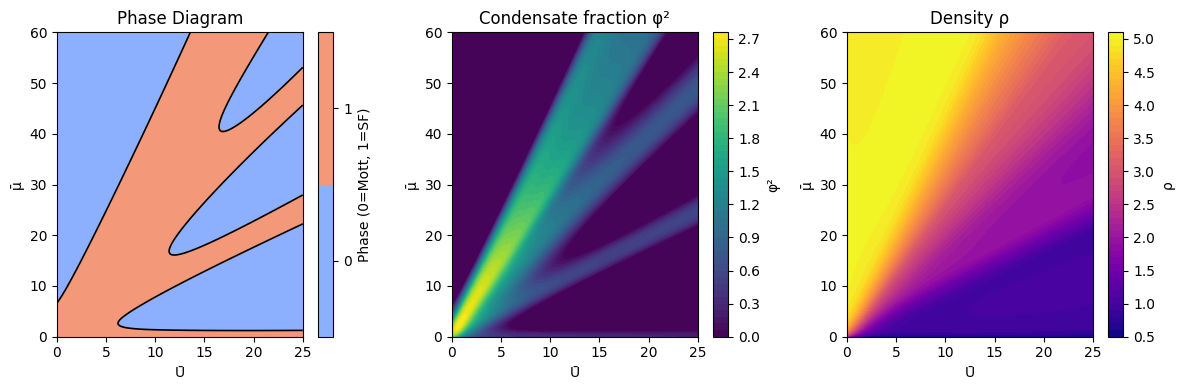

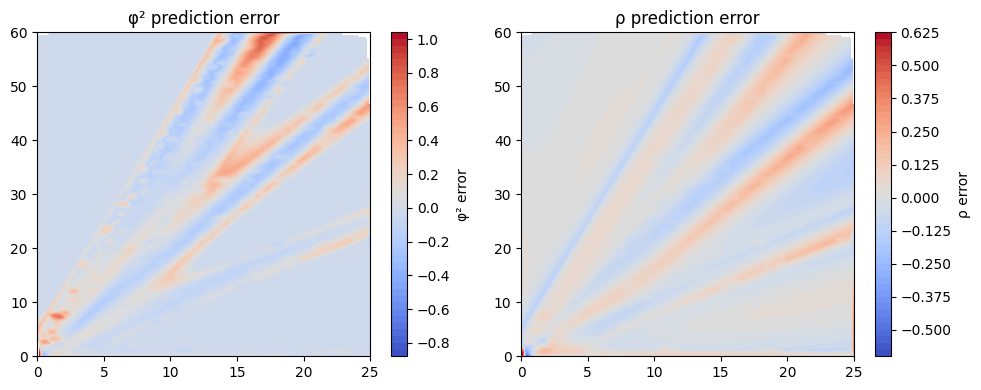

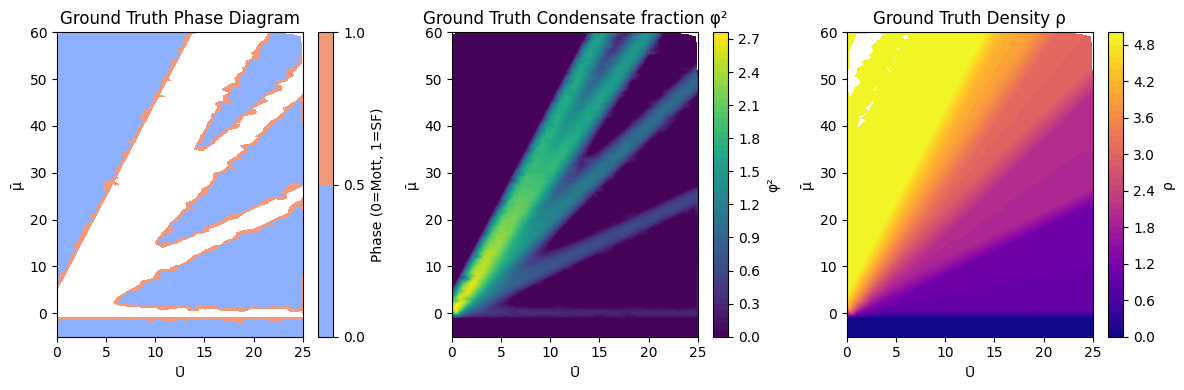


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.8884    0.9630    0.9242      2000
           1     0.9706    0.9098    0.9392      2684

    accuracy                         0.9325      4684
   macro avg     0.9295    0.9364    0.9317      4684
weighted avg     0.9355    0.9325    0.9328      4684



C:\Users\DELL\AppData\Local\Temp\ipykernel_20628\2991935851.py:106: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [53]:
# --- 5) Phase diagram prediction ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# Predict → 4 outputs
y_pred_grid = pinn_surrogate.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred, _ = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

plt.figure(figsize=(12,4))

# --- Phase diagram ---
plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5, 0.5, 1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)  # phase boundary
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Diagram")

# --- φ² diagram ---
plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

# --- ρ diagram ---
plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout()
plt.show()

from scipy.interpolate import griddata

# Ground truth values
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

# Compute errors on grid
phi2_err = phi2_pred - phi2_true_interp
rho_err  = rho_pred - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()



# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report ---
y_pred_phase, y_pred_phi2, y_pred_rho, _ = pinn_surrogate.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


In [54]:
# --- 6) Classification report on FULL dataset ---
df_full = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")
df_full["Phase"] = df_full.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

X_full = df_full[["Ubar","Mubar"]].values.astype(np.float32)
y_true_full = df_full["Phase"].astype(int).ravel()

# Predict with trained model
y_pred_phase_full, _, _, _ = pinn_surrogate.predict(X_full, verbose=0)
y_pred_labels_full = (y_pred_phase_full > 0.5).astype(int).ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, FULL dataset):")
print(classification_report(y_true_full, y_pred_labels_full, digits=4))

C:\Users\DELL\AppData\Local\Temp\ipykernel_20628\1968048930.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_full = df_full["Phase"].astype(int).ravel()



📊 Classification Report (Phase, FULL dataset):
              precision    recall  f1-score   support

           0     0.9936    0.9603    0.9767     97450
           1     0.9442    0.9908    0.9669     65951

    accuracy                         0.9727    163401
   macro avg     0.9689    0.9756    0.9718    163401
weighted avg     0.9736    0.9727    0.9728    163401



In [ ]:
# def build_and_train_model(X, y, epochs=50, batch_size=128):
#     """
#     Simple wrapper to build and train the surrogate PINN model.
#     """
#     # Build model
#     inputs = keras.Input(shape=(X.shape[1],))
#     h = layers.Dense(64, activation="relu")(inputs)
#     h = layers.Dense(64, activation="relu")(h)

#     # Outputs: phase (binary), phi² (regression), density (regression)
#     phase_out = layers.Dense(1, activation="sigmoid", name="phase")(h)
#     phi2_out = layers.Dense(1, name="phi2")(h)
#     rho_out = layers.Dense(1, name="rho")(h)

#     model = keras.Model(inputs=inputs, outputs=[phase_out, phi2_out, rho_out])

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss={
#             "phase": "binary_crossentropy",
#             "phi2": "mse",
#             "rho": "mse"
#         },
#         metrics={"phase": "accuracy"}
#     )

#     # Train
#     model.fit(
#         X, [y["phase"], y["phi2"], y["rho"]],
#         epochs=epochs, batch_size=batch_size,
#         verbose=0
#     )
#     return model


In [ ]:
# # Full dataset (whatever you originally used)
# X_full, y_full = X, y  

# # Create reduced dataset
# X_reduced, y_reduced, keep_idx = reduce_dataset(X_full, y_full, num_points=300, transition_region=(4, 8))

# print("Full dataset size:", len(X_full))
# print("Reduced dataset size:", len(X_reduced))

# # Train two models
# model_full = build_and_train_model(X_full, y_full)       # train on full
# model_reduced = build_and_train_model(X_reduced, y_reduced)  # train on reduced

# # Evaluate both
# evaluate_model(model_full, X_full, y_full, label="Full dataset")
# evaluate_model(model_reduced, X_full, y_full, label="Reduced dataset")
